In [1]:
import shutil, os, pathlib
for p in [pathlib.Path.home()/".nv/ComputeCache",
          pathlib.Path.home()/".cache/jax",
          pathlib.Path.home()/".cache/xla"]:
    shutil.rmtree(p, ignore_errors=True)
print("caches cleared; restart kernel and re-run the first cell.")

caches cleared; restart kernel and re-run the first cell.


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ.setdefault("JAX_PLATFORMS", "cuda")
os.environ.setdefault("JAX_ENABLE_X80", "True")
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "True"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.65" 

import jax, jax.numpy as jnp

In [3]:
import os, sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

os.chdir("/home/agnes/Skyclean")       # repo root
sys.path.insert(0, os.getcwd())

from skyclean.silc.ilc import ProduceSILC
from skyclean.silc.ilc import SILCTools
from skyclean.silc.file_templates import FileTemplates
from skyclean.silc.pipeline import Pipeline
from skyclean.silc.power_spec import MapAlmConverter, PowerSpectrumTT
from skyclean.silc.map_tools import SamplingConverters, MWTools, HPTools
from skyclean.silc.download import DownloadData
from skyclean.silc.harmonic_response import HRFigures, HarmonicWindows, AxisymmetricGenerators

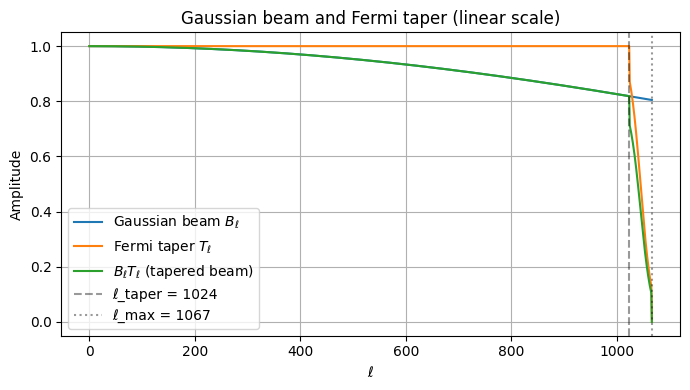

In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def debug_beam_taper(lmax: int,
                     standard_fwhm_rad: float,
                     ell_taper_frac: float = 0.96):
    """
    Plot the Gaussian beam, Fermi taper, and tapered beam as functions of ℓ.
    Uses the same logic as beam_convolve().
    """
    ells = np.arange(lmax + 1)

    # Gaussian beam
    bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax, pol=False)

    # Fermi taper in ℓ (your HPTools version)
    ell_taper = int(ell_taper_frac * lmax)
    taper = HPTools.fermi_taper(lmax + 1, ell_taper, ell_max=lmax)

    # Tapered effective beam
    bl_tapered = bl * taper

    # --- Plot (linear scale) ---
    plt.figure(figsize=(7, 4))

    plt.plot(ells, bl,         label="Gaussian beam $B_\\ell$")
    plt.plot(ells, taper,      label="Fermi taper $T_\\ell$")
    plt.plot(ells, bl_tapered, label="$B_\\ell T_\\ell$ (tapered beam)")

    plt.axvline(ell_taper, color="k", ls="--", alpha=0.4,
                label=f"ℓ_taper = {ell_taper}")
    plt.axvline(lmax, color="k", ls=":", alpha=0.4,
                label=f"ℓ_max = {lmax}")

    plt.xlabel(r"$\ell$")
    plt.ylabel(r"Amplitude")
    plt.title("Gaussian beam and Fermi taper (linear scale)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

lmax = 1067
fwhm_arcmin = 5.0
fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)

debug_beam_taper(lmax, fwhm_rad, ell_taper_frac=0.96)


In [5]:
import numpy as np
import healpy as hp

def aliasing_test(lmax, ell0, m0, method="jax_cuda"):
    """
    Direct aliasing test for the Healpix <-> MW map roundtrip.

    Pipeline under test:
        alm_in (single mode) -> hp_map (alm2map)
        -> mw_map = HPTools.hp_map_2_mw_map
        -> hp_map_back = HPTools.mw_map_2_hp_map
        -> alm_out = map2alm(hp_map_back)

    Any power in alm_out outside (ell0, m0) is leakage / aliasing / mode mixing
    from the hp<->MW machinery.
    """
    # nside consistent with lmax 
    nside = HPTools.get_nside_from_lmax(lmax)

    # 1) Build input alm with only one non-zero mode
    alm_in = np.zeros(hp.Alm.getsize(lmax), dtype=complex)
    idx = hp.Alm.getidx(lmax, ell0, m0)
    alm_in[idx] = 1.0 + 0j

    # 2) alm -> Healpix map
    hp_map = hp.alm2map(alm_in, nside=nside, lmax=lmax, verbose=False)

    # 3) Healpix -> MW map (your existing function)
    mw_map = SamplingConverters.hp_map_2_mw_map(hp_map, lmax, method=method)

    # 4) MW -> Healpix map (your existing function)
    hp_map_back = SamplingConverters.mw_map_2_hp_map(mw_map, lmax, method=method)

    # 5) Back to alm
    alm_out = hp.map2alm(hp_map_back, lmax=lmax, verbose=False)

    # 6) Measure leakage: power outside (ell0, m0)
    power_total = np.sum(np.abs(alm_out)**2)
    power_main  = np.abs(alm_out[idx])**2
    power_leak  = power_total - power_main
    leak_frac = power_leak / power_total if power_total > 0 else 0.0

    print(f"[HP↔MW roundtrip] (ell0, m0) = ({ell0}, {m0})")
    print(f"  |alm_out[ell0,m0]| = {np.abs(alm_out[idx]):.3e}")
    print(f"  leakage fraction   = {leak_frac:.3e}")

    return leak_frac, alm_in, alm_out

lmax = 128
ell0 = 120
m0   = 0
leak_frac, alm_in, alm_out = aliasing_test(
    lmax=lmax, ell0=ell0, m0=m0, method="jax_cuda"
)

[HP↔MW roundtrip] (ell0, m0) = (120, 0)
  |alm_out[ell0,m0]| = 1.000e+00
  leakage fraction   = 6.422e-09


[HP↔MW roundtrip] (ell0,m0) = (120,0)
  |alm_out[ell0,m0]| = 1.000e+00
  leakage fraction   = 6.422e-09


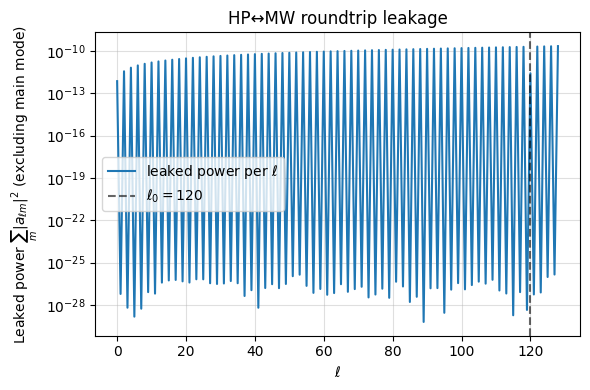

In [6]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def aliasing_test_hp_mw(lmax, ell0, m0, method="jax_cuda"):
    """
    Direct aliasing test for the Healpix <-> MW map roundtrip.

    Pipeline under test:
        alm_in (single mode) -> hp_map (alm2map)
        -> mw_map = SamplingConverters.hp_map_2_mw_map
        -> hp_map_back = SamplingConverters.mw_map_2_hp_map
        -> alm_out = map2alm(hp_map_back)

    Any power in alm_out outside (ell0, m0) is leakage / mode mixing
    from the hp<->MW machinery.
    """
    nside = HPTools.get_nside_from_lmax(lmax)

    # 1) Build input alm with only one non-zero mode
    alm_in = np.zeros(hp.Alm.getsize(lmax), dtype=complex)
    idx = hp.Alm.getidx(lmax, ell0, m0)
    alm_in[idx] = 1.0 + 0j

    # 2) alm -> Healpix map
    hp_map = hp.alm2map(alm_in, nside=nside, lmax=lmax, verbose=False)

    # 3) Healpix -> MW map
    mw_map = SamplingConverters.hp_map_2_mw_map(hp_map, lmax, method=method)

    # 4) MW -> Healpix map
    hp_map_back = SamplingConverters.mw_map_2_hp_map(mw_map, lmax, method=method)

    # 5) Back to alm
    alm_out = hp.map2alm(hp_map_back, lmax=lmax, verbose=False)

    # 6) Measure leakage: power outside (ell0, m0)
    power_total = np.sum(np.abs(alm_out)**2)
    power_main  = np.abs(alm_out[idx])**2
    power_leak  = power_total - power_main
    leak_frac = power_leak / power_total if power_total > 0 else 0.0

    print(f"[HP↔MW roundtrip] (ell0,m0) = ({ell0},{m0})")
    print(f"  |alm_out[ell0,m0]| = {np.abs(alm_out[idx]):.3e}")
    print(f"  leakage fraction   = {leak_frac:.3e}")

    # return maps so we can plot if we want
    return leak_frac, alm_in, alm_out, hp_map, hp_map_back

lmax = 128
ell0 = 120
m0   = 0

leak_frac, alm_in, alm_out, hp_map_in, hp_map_out = aliasing_test_hp_mw(
    lmax=lmax,
    ell0=ell0,
    m0=m0,
    method="jax_cuda",
)

def plot_leakage_vs_ell(alm_out, lmax, ell0, m0, title="HP↔MW leakage"):
    idx_main = hp.Alm.getidx(lmax, ell0, m0)

    ells = np.arange(lmax + 1)
    leak_per_ell = np.zeros_like(ells, dtype=float)

    for ell in range(lmax + 1):
        ms = np.arange(ell + 1)
        idxs = hp.Alm.getidx(lmax, ell, ms)

        power_ell = np.sum(np.abs(alm_out[idxs])**2)
        if ell == ell0:
            power_ell -= np.abs(alm_out[idx_main])**2  # remove main mode

        leak_per_ell[ell] = power_ell

    plt.figure(figsize=(6, 4))
    plt.semilogy(ells, leak_per_ell + 1e-40, label=r"leaked power per $\ell$")
    plt.axvline(ell0, color="k", linestyle="--", alpha=0.6, label=fr"$\ell_0={ell0}$")
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"Leaked power $\sum_m |a_{\ell m}|^2$ (excluding main mode)")
    plt.grid(alpha=0.4)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_leakage_vs_ell(alm_out, lmax, ell0, m0, title="HP↔MW roundtrip leakage")


[beam_convolve] (ell0,m0)=(120,0)
  |alm_out[ell0,m0]| = 9.972e-01
  leakage fraction   = 5.989e-09


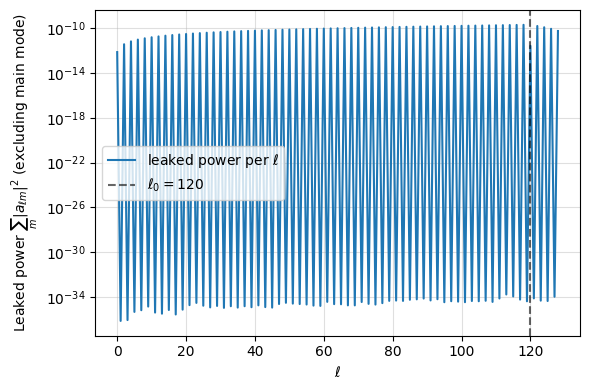

In [7]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def aliasing_test_beam_convolve(lmax, ell0, m0, standard_fwhm_rad, ell_taper_frac=0.94):
    """
    Direct aliasing test for HPTools.beam_convolve.

    - Start with alm that has ONLY (ell0,m0).
    - alm -> hp_map
    - hp_map_beam = beam_convolve(hp_map, ...)
    - hp_map_beam -> alm_out
    - Measure leakage out of (ell0,m0).
    """
    nside = HPTools.get_nside_from_lmax(lmax)

    # 1) single-mode alm
    alm_in = np.zeros(hp.Alm.getsize(lmax), dtype=complex)
    idx = hp.Alm.getidx(lmax, ell0, m0)
    alm_in[idx] = 1.0 + 0j

    # 2) alm -> hp map (input sky)
    hp_map = hp.alm2map(alm_in, nside=nside, lmax=lmax, verbose=False)

    # 3) apply your tapered beam
    hp_map_beam = HPTools.beam_convolve(
        hp_map,
        lmax=lmax,
        standard_fwhm_rad=standard_fwhm_rad,
        ell_taper_frac=ell_taper_frac,
    )

    # 4) hp_map_beam -> alm_out
    alm_out = hp.map2alm(hp_map_beam, lmax=lmax, verbose=False)

    # 5) leakage fraction
    power_total = np.sum(np.abs(alm_out)**2)
    power_main  = np.abs(alm_out[idx])**2
    power_leak  = power_total - power_main
    leak_frac   = power_leak / power_total if power_total > 0 else 0.0

    print(f"[beam_convolve] (ell0,m0)=({ell0},{m0})")
    print(f"  |alm_out[ell0,m0]| = {np.abs(alm_out[idx]):.3e}")
    print(f"  leakage fraction   = {leak_frac:.3e}")

    # return maps as well so we can plot them
    return leak_frac, alm_in, alm_out, hp_map, hp_map_beam

lmax = 128
ell0 = 120
m0   = 0
fwhm_rad = np.deg2rad(5.0 / 60.0)  # 5 arcmin

leak_frac_beam, alm_in, alm_out, hp_map_in, hp_map_beam = aliasing_test_beam_convolve(
    lmax,
    ell0,
    m0,
    standard_fwhm_rad=fwhm_rad,
    ell_taper_frac=0.94,
)

def plot_beam_leakage_vs_ell(alm_out, lmax, ell0, m0):
    idx_main = hp.Alm.getidx(lmax, ell0, m0)

    ells = np.arange(lmax + 1)
    leak_per_ell = np.zeros_like(ells, dtype=float)

    for ell in range(lmax + 1):
        ms = np.arange(ell + 1)
        idxs = hp.Alm.getidx(lmax, ell, ms)

        power_ell = np.sum(np.abs(alm_out[idxs])**2)
        if ell == ell0:
            power_ell -= np.abs(alm_out[idx_main])**2  # remove main mode
            #power_ell = np.abs(alm_out[idx_main])**2 

        leak_per_ell[ell] = power_ell

    plt.figure(figsize=(6, 4))
    plt.semilogy(ells, leak_per_ell + 1e-40, label=r"leaked power per $\ell$")
    plt.axvline(ell0, color="k", linestyle="--", alpha=0.6, label=fr"$\ell_0={ell0}$")
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"Leaked power $\sum_m |a_{\ell m}|^2$ (excluding main mode)")
    plt.grid(alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_beam_leakage_vs_ell(alm_out, lmax, ell0, m0)

[wavelet_roundtrip] (ell0,m0)=(120,0)
  |alm_out[ell0,m0]| = 1.000e+00
  leakage fraction   = 6.422e-09


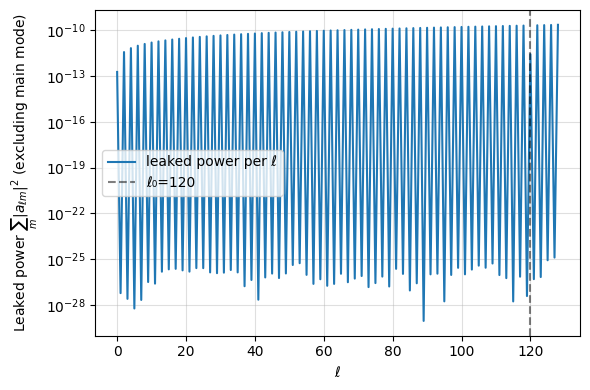

In [8]:
def aliasing_test_wavelet_roundtrip(lmax, ell0, m0,
                                    N_directions=1,
                                    lam=2.0,
                                    method="jax_cuda"):
    """
    Direct aliasing test for:
        HP map -> MW map -> wavelet analysis -> inverse wavelet -> MW map -> HP map

    Uses a single (ell0,m0) mode as input.
    """
    L = lmax + 1
    nside = HPTools.get_nside_from_lmax(lmax)

    # 1) single-mode alm
    alm_in = np.zeros(hp.Alm.getsize(lmax), dtype=complex)
    idx = hp.Alm.getidx(lmax, ell0, m0)
    alm_in[idx] = 1.0 + 0j

    # 2) alm -> hp map (input sky)
    hp_map = hp.alm2map(alm_in, nside=nside, lmax=lmax, verbose=False)

    # 3) HP -> MW
    mw_map = SamplingConverters.hp_map_2_mw_map(hp_map, lmax, method=method)

    # 4) MW -> wavelet coeffs
    wavelet_coeffs, scaling_coeffs = MWTools.wavelet_transform_from_map(
        mw_map,
        L=L,
        N_directions=N_directions,
        lam=lam,
    )

    # 5) inverse wavelet -> MW map back
    mw_map_back = MWTools.inverse_wavelet_transform(
        wavelet_coeffs,
        L=L,
        N_directions=N_directions,
        lam=lam,
    )

    # 6) MW -> HP (output sky)
    hp_map_back = SamplingConverters.mw_map_2_hp_map(mw_map_back, lmax, method=method)

    # 7) hp_map_back -> alm_out
    alm_out = hp.map2alm(hp_map_back, lmax=lmax, verbose=False)

    # 8) leakage fraction
    power_total = np.sum(np.abs(alm_out)**2)
    power_main  = np.abs(alm_out[idx])**2
    power_leak  = power_total - power_main
    leak_frac   = power_leak / power_total if power_total > 0 else 0.0

    print(f"[wavelet_roundtrip] (ell0,m0)=({ell0},{m0})")
    print(f"  |alm_out[ell0,m0]| = {np.abs(alm_out[idx]):.3e}")
    print(f"  leakage fraction   = {leak_frac:.3e}")

    # return maps as well for plotting
    return leak_frac, alm_in, alm_out, hp_map, hp_map_back

lmax = 128
ell0 = 120
m0   = 0

leak_frac, alm_in, alm_out, hp_map_in, hp_map_out = aliasing_test_wavelet_roundtrip(
    lmax,
    ell0,
    m0,
    N_directions=1,
    lam=2.0,
    method="jax_cuda",
)

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

def plot_leakage_vs_ell(alm_out, lmax, ell0, m0):
    # index of the main mode
    idx_main = hp.Alm.getidx(lmax, ell0, m0)

    ells = np.arange(lmax+1)
    leak_per_ell = np.zeros_like(ells, dtype=float)

    for ell in range(lmax+1):
        ms = np.arange(ell+1)
        idxs = hp.Alm.getidx(lmax, ell, ms)

        # total power at this ell
        power_ell = np.sum(np.abs(alm_out[idxs])**2)

        # subtract main mode power if this is ell0
        if ell == ell0:
            power_ell -= np.abs(alm_out[idx_main])**2

        leak_per_ell[ell] = power_ell

    plt.figure(figsize=(6,4))
    plt.semilogy(ells, leak_per_ell + 1e-30, label="leaked power per ℓ")
    plt.axvline(ell0, color="k", linestyle="--", alpha=0.5, label=f"ℓ₀={ell0}")
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"Leaked power $\sum_m |a_{\ell m}|^2$ (excluding main mode)")
    plt.grid(alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_leakage_vs_ell(alm_out, lmax, ell0, m0)

In [4]:
directory = "/Scratch/agnes/data" 
ft = FileTemplates(directory).file_templates

# INPUT wavelet coeff template (uses {comp}, {frequency}, {scale}, {realisation:05d}, {lmax}, {lam})
file_template = ft.get("wavelet_coeffs") or ft["wavelet_c_j"]

# OUTPUT templates expected by ILC_wav_coeff_maps_MP (use {component}, {extract_comp}, {realisation})
output_templates = {
    "doubled_maps":           ft["doubled_maps"],
    "covariance_matrices":    ft["covariance_matrices"],
    "weight_vector_matrices": ft["weight_vector_matrices"],
    "ilc_maps":               ft["ilc_maps"],
    "trimmed_maps":           ft["trimmed_maps"],
    "ilc_synth":              ft["ilc_synth"],
    "ilc_spectrum":           ft.get("ilc_spectrum"),  
    "scaling_coeffs":         ft["scaling_coeffs"], 
    "f_scal":                 ft["f_scal"],
}

In [5]:
if __name__ == "__main__":                    
    import multiprocessing as mp
    mp.set_start_method("spawn", force=True) 

In [6]:
pipe = Pipeline( 
    components=['tsz'], 
    wavelet_components=["cfn"], 
    ilc_components=['cmb'], 
    frequencies=["030","044","070","100","143","217","353","545","857"], 
    realisations=1, 
    start_realisation=0, 
    lmax=171, 
    N_directions=1, 
    lam=2.0, 
    method="jax_cuda", 
    visualise=True, 
    save_ilc_intermediates=True,
    overwrite=True, 
    directory="/Scratch/agnes/data", 
    constraint=True,
    )

In [7]:
pipe.step_download()
pipe.step_process()

--- STARTING DATA DOWNLOAD ---
Device 0: bytes_in_use=0 peak_bytes_in_use=0 bytes_limit=19069206528 largest_free_chunk=n/a num_allocs=0
File /Scratch/agnes/data/CMB_realisations/tsz_f030.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f044.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f070.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f100.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f143.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f217.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f353.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f545.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f857.fits already exists. Skipping download.
0
CMB realisation 0 already exists. Skipping 

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 030 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f030_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 044 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f044_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 070 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f070_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 100 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f100_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 143 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f143_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 217 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f217_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 353 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f353_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 545 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f545_r0000_lmax171.npy


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


CFN map at 857 GHz for realisation 0 saved to /Scratch/agnes/data/CFN_realisations/cfn_f857_r0000_lmax171.npy


--- PRODUCING WAVELET TRANSFORMS ---
Device 0: bytes_in_use=0 peak_bytes_in_use=0 bytes_limit=19069206528 largest_free_chunk=n/a num_allocs=0


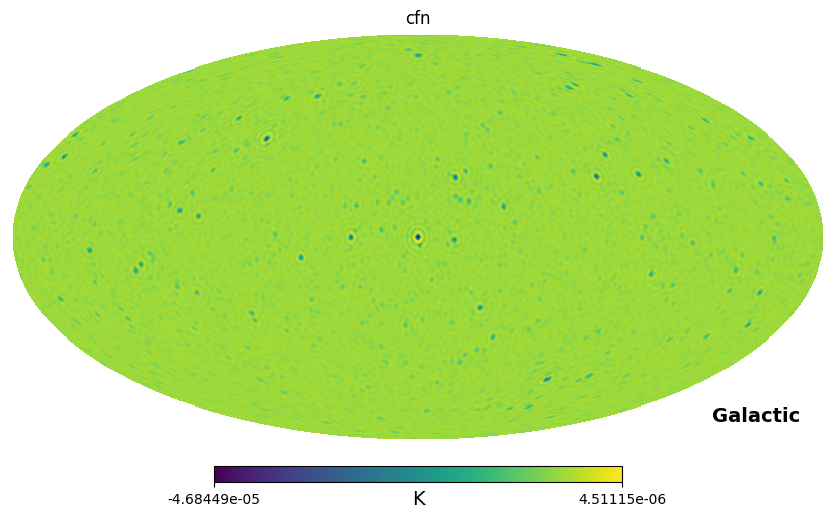

Wavelet transform for cfn at 030 GHz for realisation 0 saved.


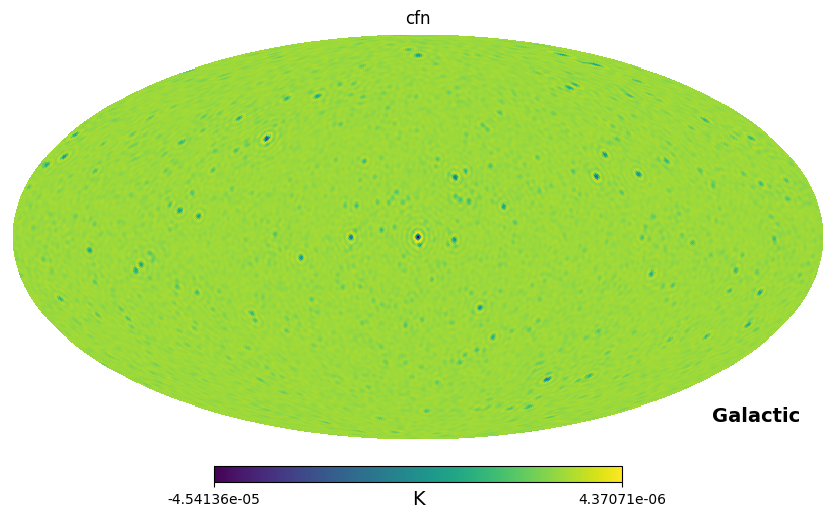

Wavelet transform for cfn at 044 GHz for realisation 0 saved.


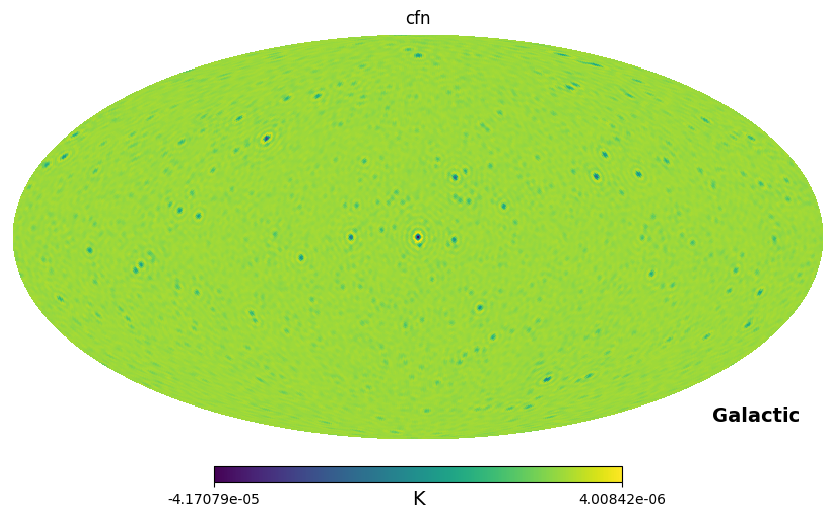

Wavelet transform for cfn at 070 GHz for realisation 0 saved.


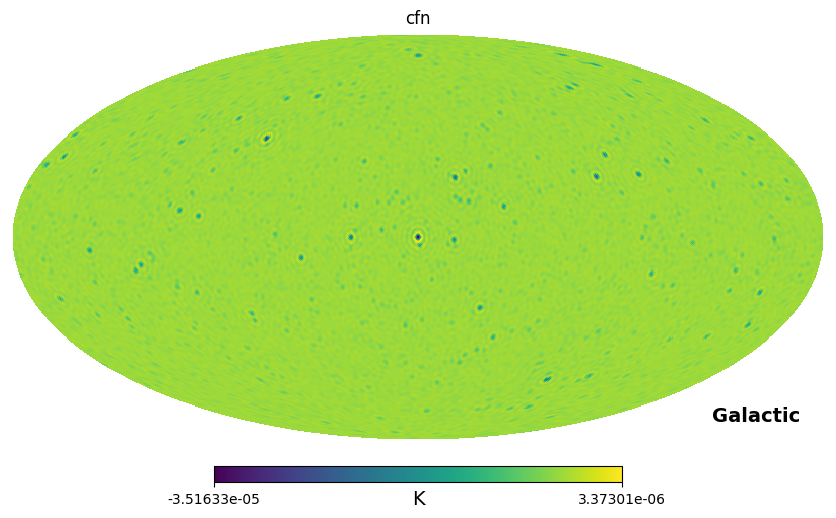

Wavelet transform for cfn at 100 GHz for realisation 0 saved.


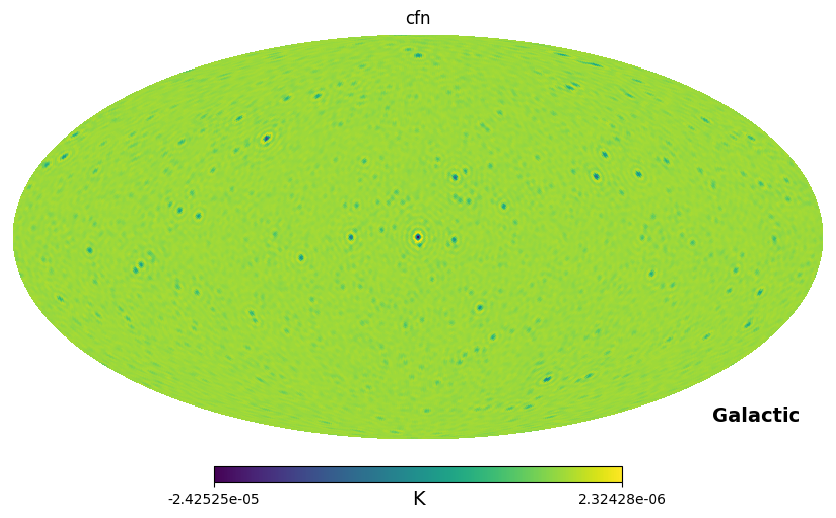

Wavelet transform for cfn at 143 GHz for realisation 0 saved.


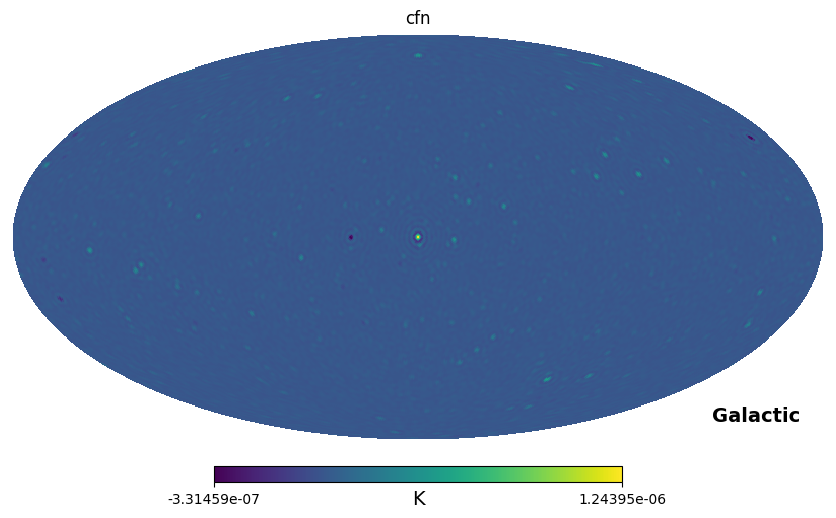

Wavelet transform for cfn at 217 GHz for realisation 0 saved.


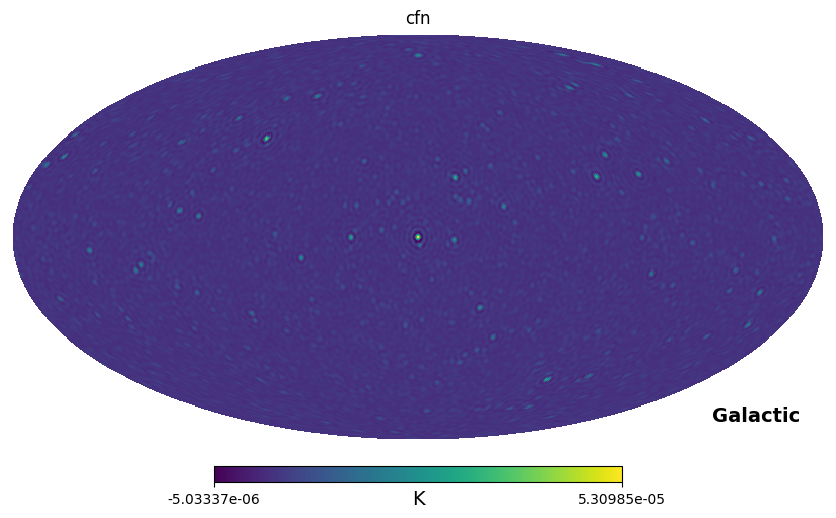

Wavelet transform for cfn at 353 GHz for realisation 0 saved.


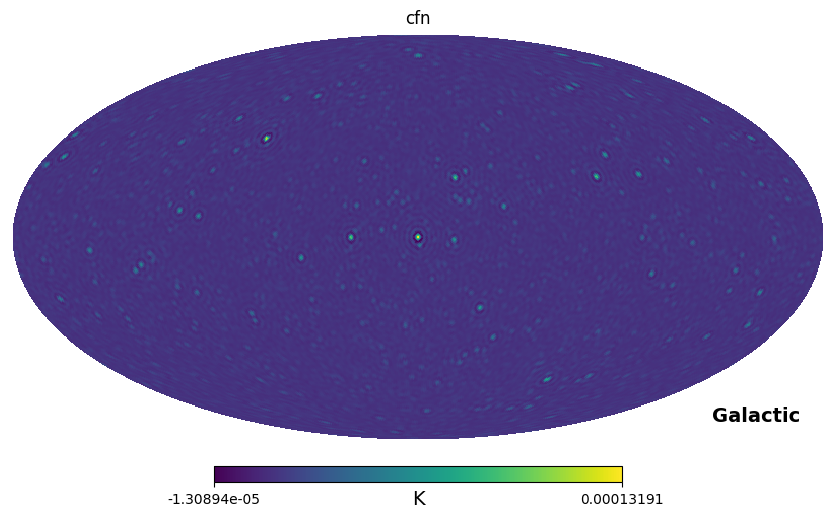

Wavelet transform for cfn at 545 GHz for realisation 0 saved.


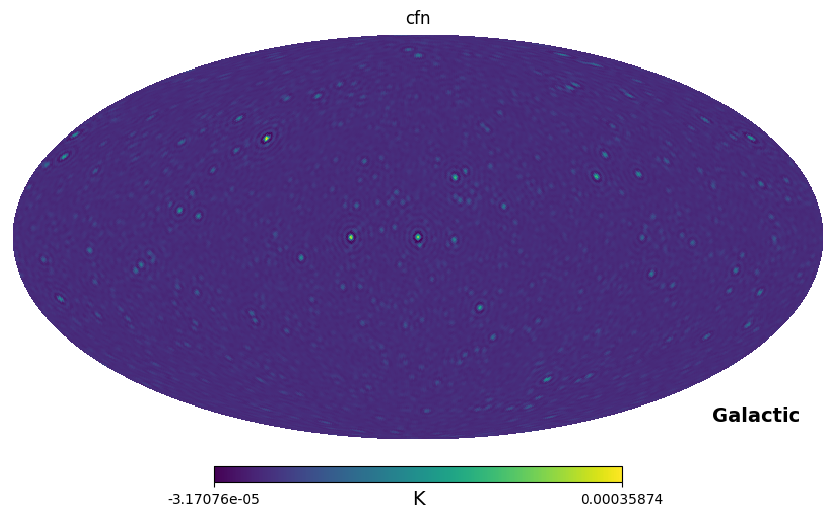

Wavelet transform for cfn at 857 GHz for realisation 0 saved.


In [8]:
pipe.step_wavelets()

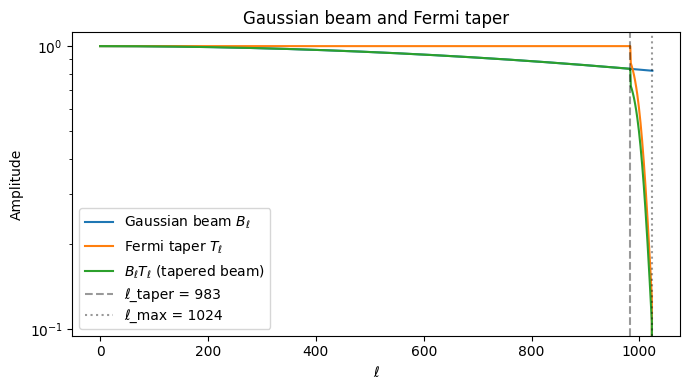

In [14]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def debug_beam_taper(lmax: int,
                     standard_fwhm_rad: float,
                     ell_taper_frac: float = 0.96):
    """
    Plot the Gaussian beam, Fermi taper, and tapered beam as functions of ℓ.
    Uses the same logic as beam_convolve().
    """
    ells = np.arange(lmax + 1)

    # Gaussian beam
    bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax, pol=False)

    # Fermi taper in ℓ (your HPTools version)
    ell_taper = int(ell_taper_frac * lmax)
    taper = HPTools.fermi_taper(lmax + 1, ell_taper, ell_max=lmax)

    # Tapered effective beam
    bl_tapered = bl * taper

    # --- Plot ---
    plt.figure(figsize=(7, 4))
    plt.semilogy(ells, bl,         label="Gaussian beam $B_\\ell$")
    plt.semilogy(ells, taper,      label="Fermi taper $T_\\ell$")
    plt.semilogy(ells, bl_tapered, label="$B_\\ell T_\\ell$ (tapered beam)")

    plt.axvline(ell_taper, color="k", ls="--", alpha=0.4,
                label=f"ℓ_taper = {ell_taper}")
    plt.axvline(lmax, color="k", ls=":", alpha=0.4,
                label=f"ℓ_max = {lmax}")

    plt.xlabel(r"$\ell$")
    plt.ylabel(r"Amplitude")
    plt.title("Gaussian beam and Fermi taper")
    plt.legend()
    plt.tight_layout()
    plt.show()

lmax = 1024
fwhm_arcmin = 5.0
fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)

debug_beam_taper(lmax, fwhm_rad, ell_taper_frac=0.96)


# (1) n_side consistency


Input map

In [15]:
import healpy as hp
from pathlib import Path

files = {
    "noise_f030_r00000.fits": "/Scratch/agnes/data/CMB_realisations/noise_f030_r00000.fits",
    "tsz_f030.fits":          "/Scratch/agnes/data/CMB_realisations/tsz_f030.fits",
    "cmb_r0000.fits":         "/Scratch/agnes/data/CMB_realisations/cmb_r0000.fits",
    "sync_f030.fits":         "/Scratch/agnes/data/CMB_realisations/sync_f030.fits",
}

for name, path in files.items():
    m = hp.read_map(path, verbose=False)
    print(f"{name}: NSIDE={hp.get_nside(m)}")


noise_f030_r00000.fits: NSIDE=1024
tsz_f030.fits: NSIDE=2048
cmb_r0000.fits: NSIDE=2048
sync_f030.fits: NSIDE=2048


Processed map when lmax = 128

In [16]:
import numpy as np
import healpy as hp

# params
directory   = "/Scratch/agnes/data/"
frequency   = "030"
realisation = 0
lmax        = 256

ft = FileTemplates(directory=directory)

files = {
    "processed_cmb":   ft.file_templates["processed_cmb"].format(realisation=realisation, lmax=lmax),
    "processed_sync":  ft.file_templates["processed_sync"].format(frequency=frequency, lmax=lmax),
    "processed_noise": ft.file_templates["processed_noise"].format(frequency=frequency, realisation=realisation, lmax=lmax),
    "processed_tsz":   ft.file_templates["processed_tsz"].format(frequency=frequency, lmax=lmax),
    "cfn":             ft.file_templates["cfn"].format(frequency=frequency, realisation=realisation, lmax=lmax),
}

for name, path in files.items():
    m = hp.read_map(path, verbose=False)
    print(f"{name}: NSIDE={hp.get_nside(m)}")


processed_cmb: NSIDE=128
processed_sync: NSIDE=128
processed_noise: NSIDE=128
processed_tsz: NSIDE=128
cfn: NSIDE=128


# (2) All input components are non-beamed 
https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Simulation_data

# (3) Power spectrum of individual input component and the sum

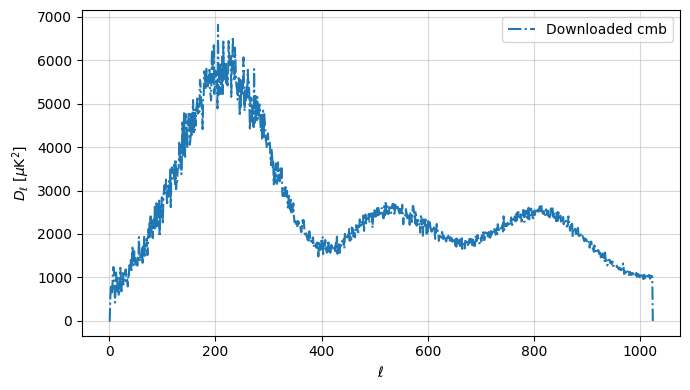

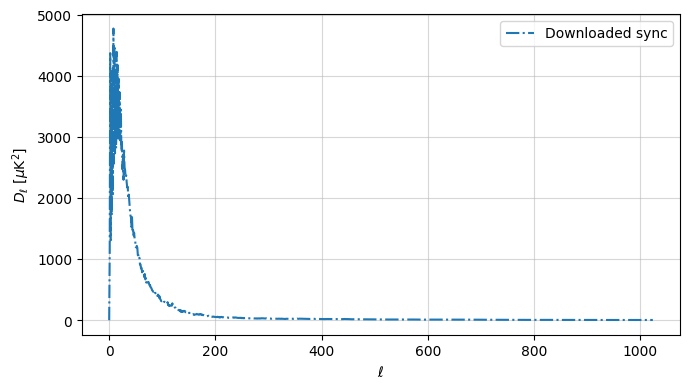

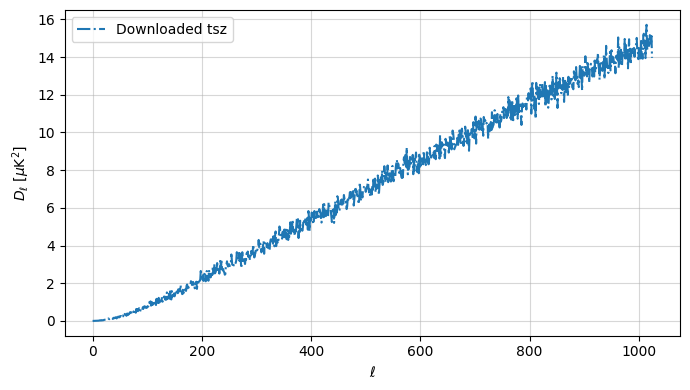

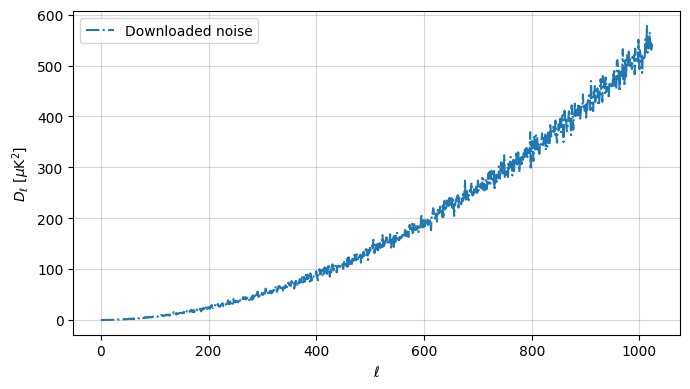

(array([   0,    1,    2, ..., 1022, 1023, 1024], shape=(1025,)),
 array([3.20548159e-09, 1.09573676e-14, 1.05003334e-14, ...,
        3.19325182e-15, 3.24545025e-15, 3.23123423e-15], shape=(1025,)))

In [17]:
lmax = 1024 
frequency = '030'

# 1) CMB (skyinbands; needs frequency)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="cmb",
    frequency=frequency,      # GHz
    lmax=lmax
)

# 2) Synchrotron (skyinbands; needs frequency)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="sync",
    frequency=frequency,      # GHz
    lmax=lmax
)

# 3) Thermal SZ (skyinbands; needs frequency)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="tsz",
    frequency=frequency,
    lmax=lmax
)

# 4) Instrument noise MC (needs frequency + realisation)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="noise",
    frequency=frequency,
    realisation=0,
    lmax=lmax
)


The power spectrum of the cfn = cmb + tsz + sync + noise

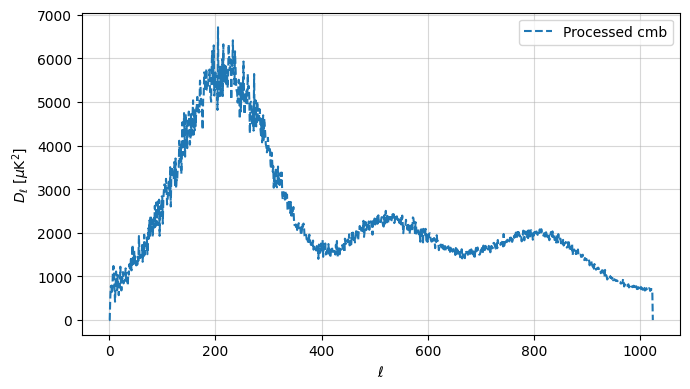

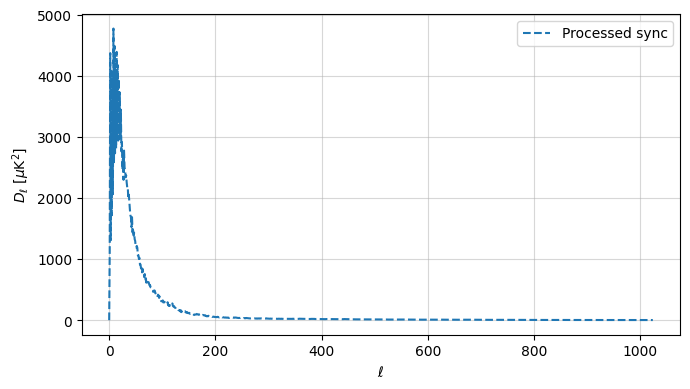

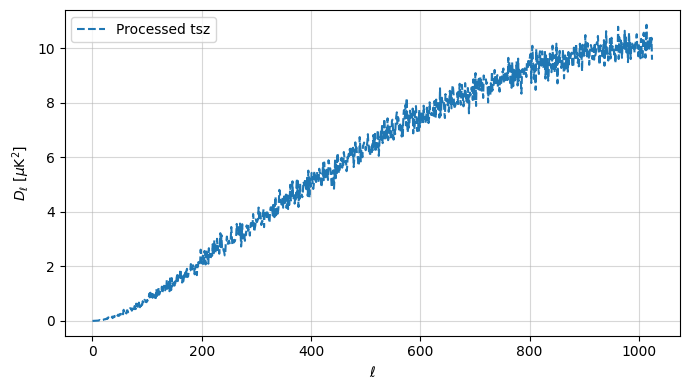

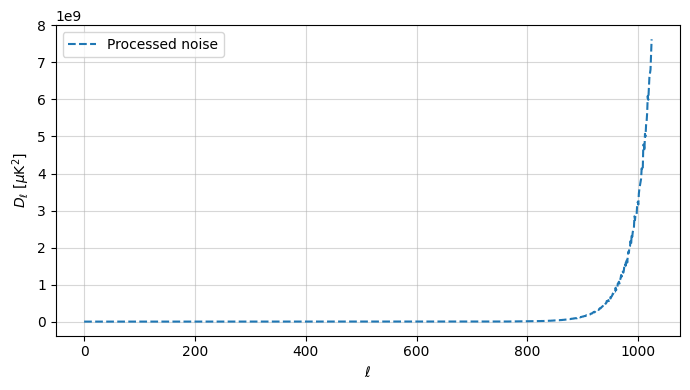

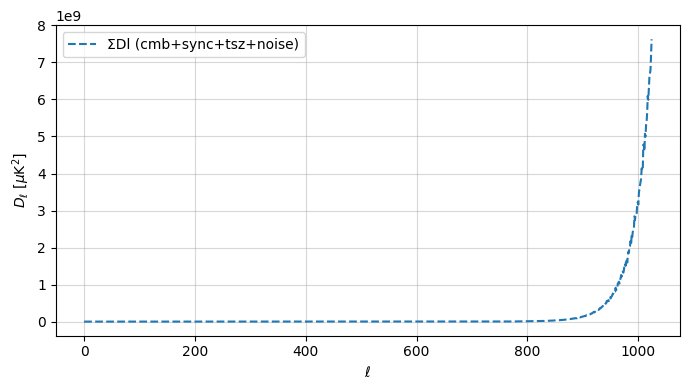

In [18]:
# --- sum of Dl from individual processed components (no alm math) ---

lmax = 1024
frequency = "030"

Dl_sum = None
ell_ref = None

def add_comp(comp, realisation=None):
    global Dl_sum, ell_ref
    ell, cl = pipe.step_power_spec(
        unit="K",
        source="processed",
        component=comp,
        frequency=frequency,
        realisation=realisation,
        lmax=lmax
    )
    Dl = PowerSpectrumTT.cl_to_Dl(ell, cl, input_unit="K")
    if Dl_sum is None:
        ell_ref = ell
        Dl_sum = Dl.copy()
    else:
        # assume same l-grid (same lmax) because we passed lmax explicitly
        Dl_sum += Dl

# 1) CMB
add_comp("cmb")
# 2) Synchrotron
add_comp("sync")
# 3) tSZ
add_comp("tsz")
# 4) Noise (specify realisation)
add_comp("noise", realisation=0)

# Plot the summed Dl
PowerSpectrumTT.plot_Dl_series([
    {"ell": ell_ref, "Dl": Dl_sum, "label": "ΣDl (cmb+sync+tsz+noise)", "source": "processed"}
])

# 'ell_ref' and 'Dl_sum' are r outputs


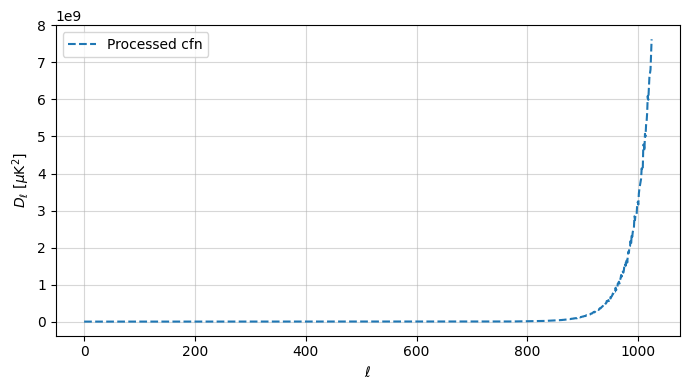

(array([   0,    1,    2, ..., 1022, 1023, 1024], shape=(1025,)),
 array([7.39901848e-08, 3.50409229e-09, 3.27936233e-09, ...,
        4.09077360e-08, 4.31768877e-08, 4.56504312e-08], shape=(1025,)))

In [19]:
lmax = 1024
pipe.step_power_spec(
    unit="K",
    source="processed",
    component="cfn",     
    frequency='030',       # GHz
    realisation=0,       # r00000
    lmax=lmax
)

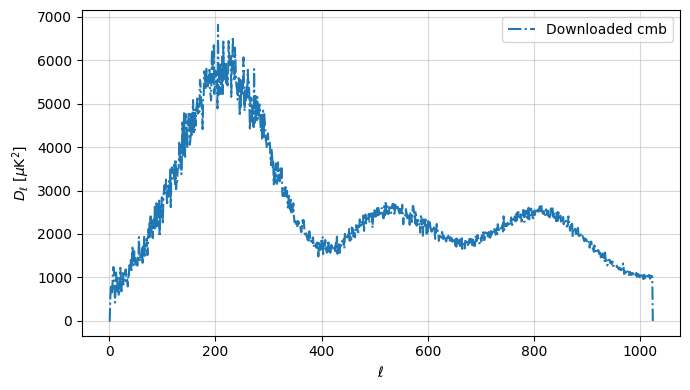

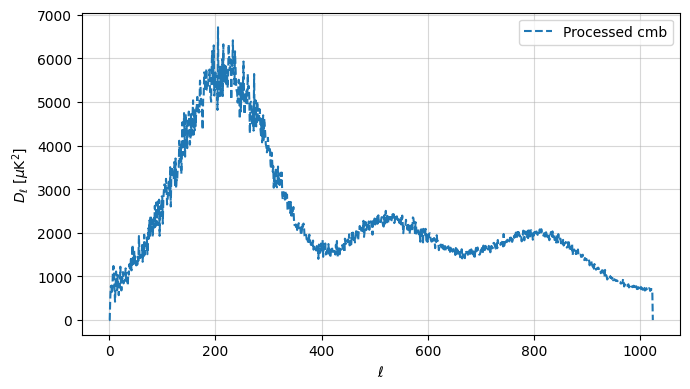

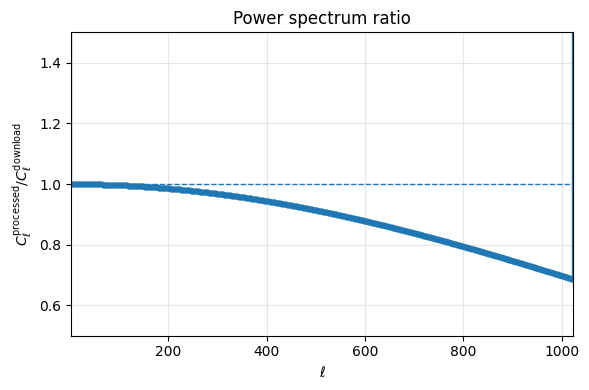

In [20]:
# --- same call used ---
ell, cl = pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="cmb",
    frequency=frequency,      # GHz
    lmax=lmax
)


# --- call the 'processed' one with identical args ---
ell_proc, cl_proc = pipe.step_power_spec(
    unit="K",
    source="processed",
    component="cmb",
    extract_comp=None,
    frequencies=None,          # processed_cmb has no freq in filename
    realisation=0,
    lmax=1024,
    lam=2.0,
)

# --- ratio (processed over ilc_synth) ---
import numpy as np
import matplotlib.pyplot as plt

# (optional but helpful) ensure ℓ match
assert np.array_equal(ell, ell_proc), "ℓ grids differ"
ell = ell
ratio = cl_proc/ cl

# --- plot ---
plt.figure(figsize=(6,4))
plt.plot(ell, ratio, marker='.', linestyle='-')
plt.axhline(1.0, linestyle='--', linewidth=1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\mathrm{processed}} / C_\ell^{\mathrm{download}}$')
plt.ylim(0.5,1.5)
plt.xlim(2,1024)
plt.title('Power spectrum ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() 

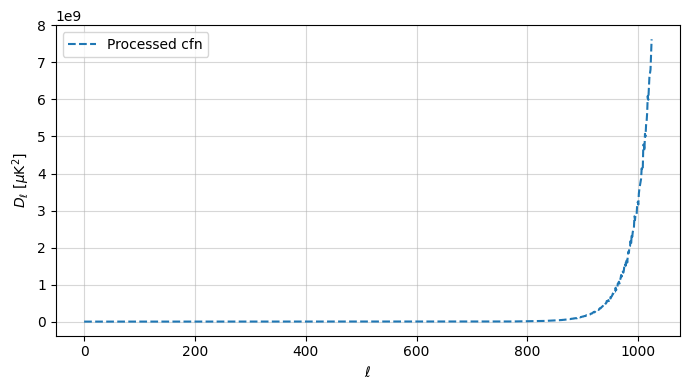

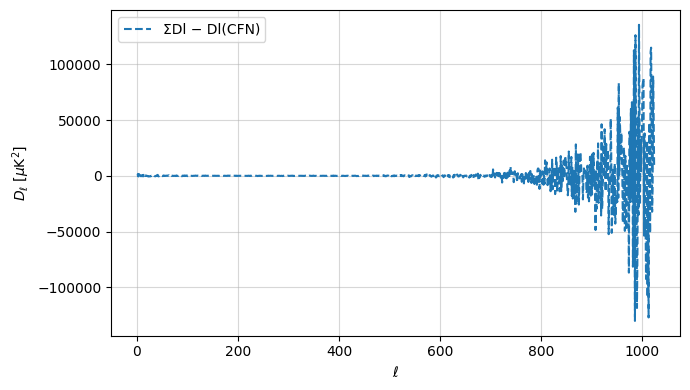

In [21]:
#  already have:
#   ell_ref, Dl_sum  (ΣDl of cmb+sync+tsz+noise at lmax=1024, frequency='030')

lmax = 1024
# CFN spectrum
ell_cfn, cl_cfn = pipe.step_power_spec(
    unit="K",
    source="processed",
    component="cfn",
    frequency="030",
    realisation=0,
    lmax=lmax
)
Dl_cfn = PowerSpectrumTT.cl_to_Dl(ell_cfn, cl_cfn, input_unit="K")

# residual = ΣDl(components) - Dl(CFN)
Dl_res = Dl_sum - Dl_cfn  

# plot residual
PowerSpectrumTT.plot_Dl_series([
    {"ell": ell_ref, "Dl": Dl_res, "label": "ΣDl − Dl(CFN)", "source": "processed"}
])


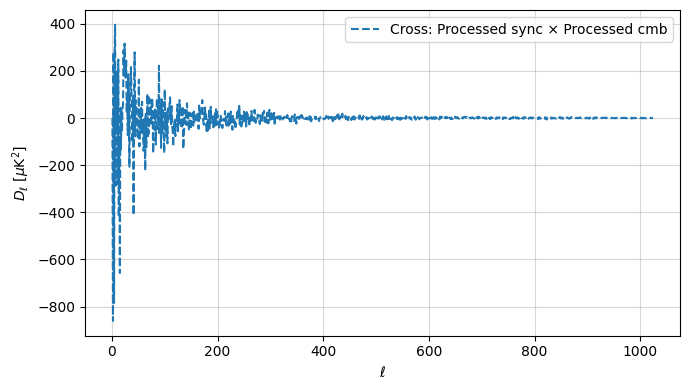

'\n# B) Cross ILC-synth (CMB target) with downloaded 143 GHz map\nell, Cl_xy = pipe.step_cross_power_spec(\n    source_X="ilc_synth", extract_comp_X="cmb", frequencies_X=["100","143","217"],  \n    source_Y="downloaded", component_Y="cmb", frequency_Y=143,                      # single band\n    lmax=3000\n)\n\n# C) Let it auto-pick sources (prefers \'processed\' if processed_cfn exists)\nell, Cl_xy = pipe.step_cross_power_spec(\n    source_X="auto",\n    source_Y="auto",\n    lmax=2048\n)\n'

In [22]:
# A) Cross between two processed components (defaults pick 'cfn' if present)
ell, Cl_xy = pipe.step_cross_power_spec(
    source_X="processed", component_X="sync", frequency_X='030',
    source_Y="processed", component_Y="cmb", frequency_Y='030',
    lmax=1024,
    unit="K",                      # input C_ell in K^2; plot shows µK^2
    save_path=None                 # or "cross_processed_cfn_cmb.png"
)

'''
# B) Cross ILC-synth (CMB target) with downloaded 143 GHz map
ell, Cl_xy = pipe.step_cross_power_spec(
    source_X="ilc_synth", extract_comp_X="cmb", frequencies_X=["100","143","217"],  
    source_Y="downloaded", component_Y="cmb", frequency_Y=143,                      # single band
    lmax=3000
)

# C) Let it auto-pick sources (prefers 'processed' if processed_cfn exists)
ell, Cl_xy = pipe.step_cross_power_spec(
    source_X="auto",
    source_Y="auto",
    lmax=2048
)
'''

For every pair

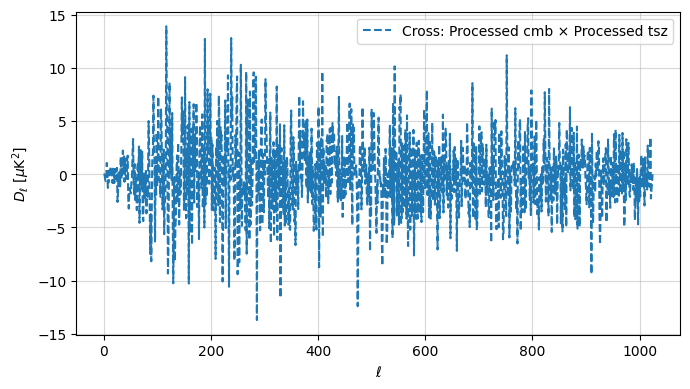

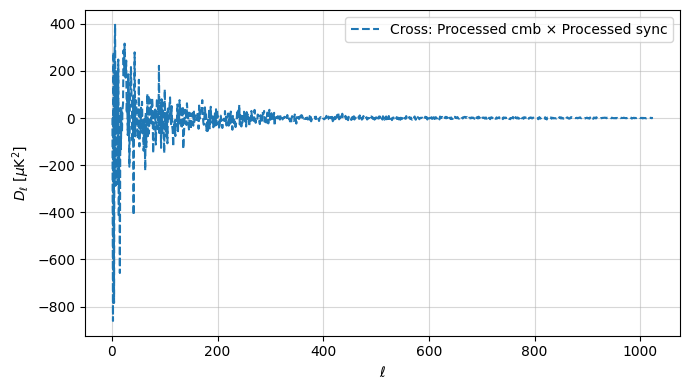

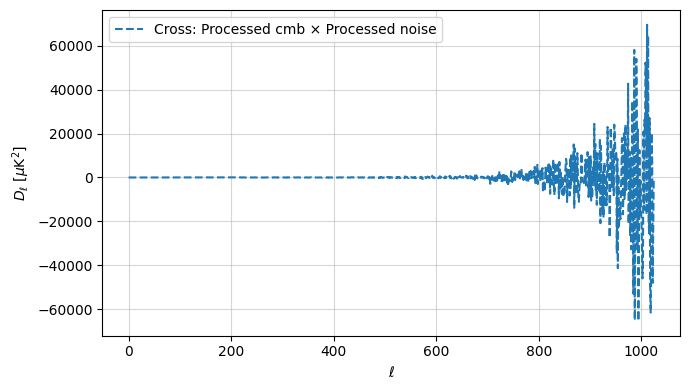

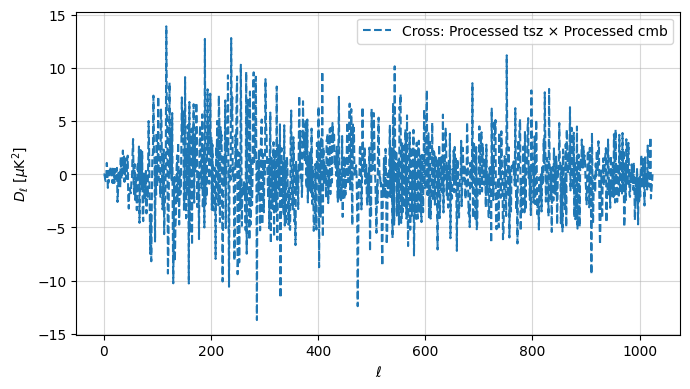

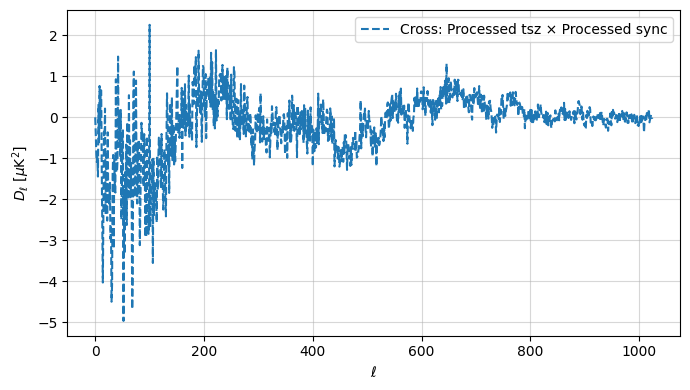

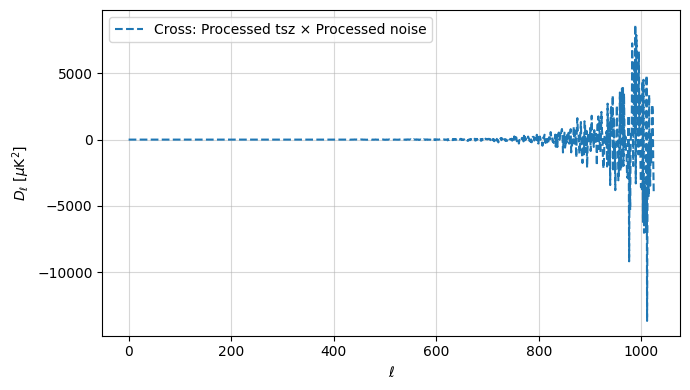

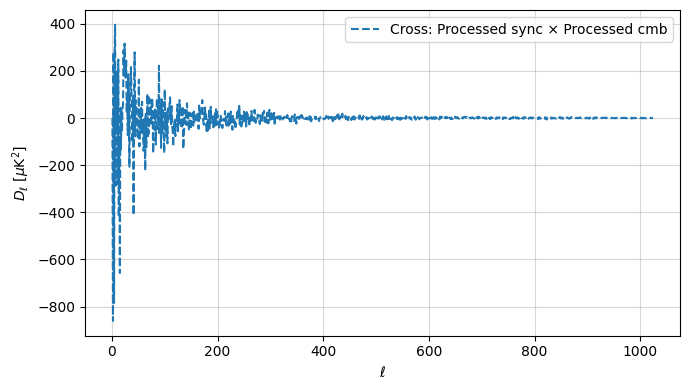

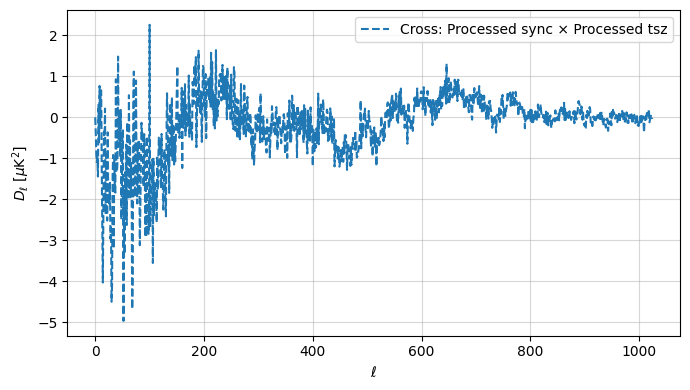

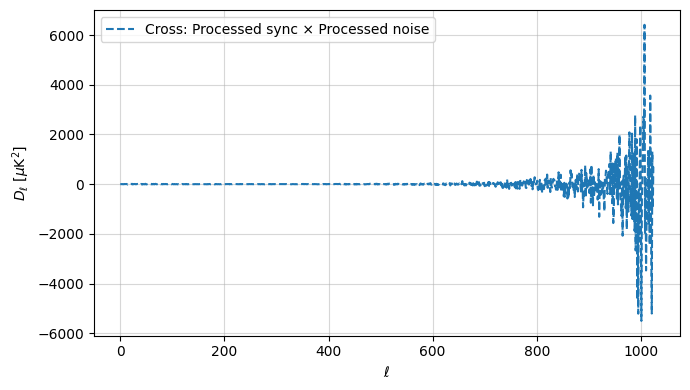

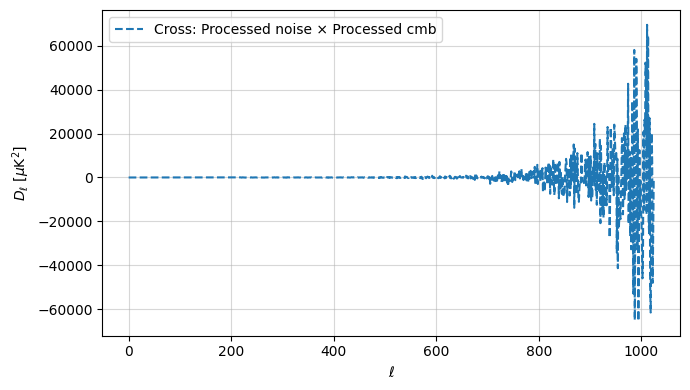

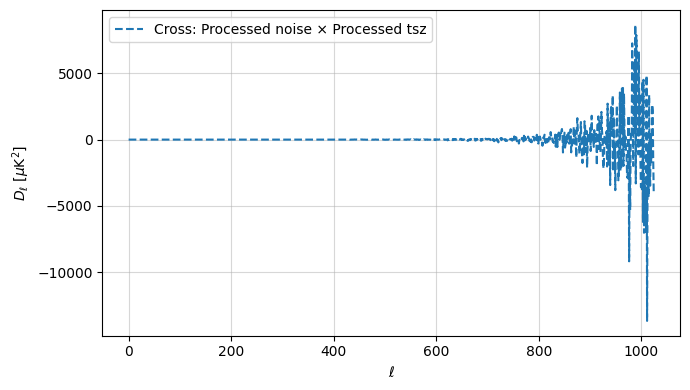

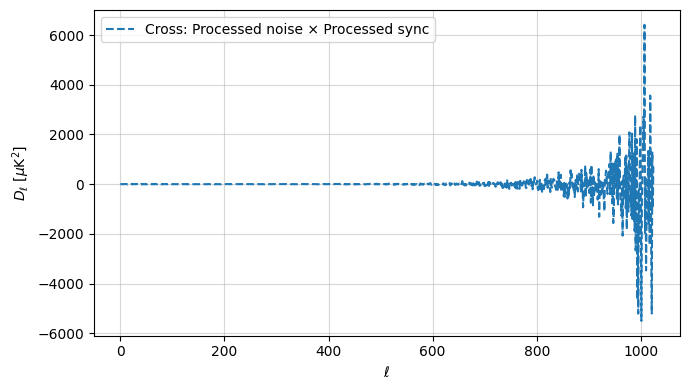

cmb × tsz :  C_0 = 5.1667e-16,  C_1 = -8.05884e-19
cmb × sync :  C_0 = -1.27612e-14,  C_1 = 3.4702e-18
cmb × noise :  C_0 = -4.93591e-18,  C_1 = -1.60651e-18
tsz × cmb :  C_0 = 5.1667e-16,  C_1 = -8.05884e-19
tsz × sync :  C_0 = -3.2512e-09,  C_1 = -1.21875e-12
tsz × noise :  C_0 = -1.25753e-12,  C_1 = 4.67683e-15
sync × cmb :  C_0 = -1.27612e-14,  C_1 = 3.4702e-18
sync × tsz :  C_0 = -3.2512e-09,  C_1 = -1.21875e-12
sync × noise :  C_0 = 3.10597e-11,  C_1 = -2.94767e-12
noise × cmb :  C_0 = -4.93591e-18,  C_1 = -1.60651e-18
noise × tsz :  C_0 = -1.25753e-12,  C_1 = 4.67683e-15
noise × sync :  C_0 = 3.10597e-11,  C_1 = -2.94767e-12


In [23]:
# build all pairs
components = ['cmb', 'tsz', 'sync', 'noise']
pairs = {}
for cx in components:
    for cy in components:
        if cx == cy:
            continue
        ell, Cl_xy = pipe.step_cross_power_spec(
            source_X="processed", component_X=cx, frequency_X='030',
            source_Y="processed", component_Y=cy, frequency_Y='030',
            lmax=1024, unit="K", save_path=None
        )
        pairs[(cx, cy)] = (ell, Cl_xy)

# check ℓ=0 and ℓ=1 for EVERY pair
for (cx, cy), (ell, Cl) in pairs.items():
    # assume ell[0]==0 and ell[1]==1; guard just in case
    cl0 = Cl[0] if ell.size > 0 and ell[0] == 0 else float('nan')
    cl1 = Cl[1] if ell.size > 1 and ell[1] == 1 else float('nan')
    print(f"{cx} × {cy} :  C_0 = {cl0:.6g},  C_1 = {cl1:.6g}")


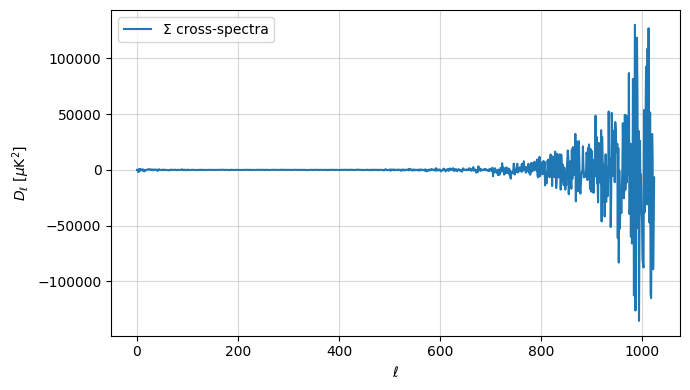

In [24]:
# Sum all cross spectra in `pairs` (built above), assuming all share the same ell
ell_sum = None
Cl_sum  = None

for (ell, Cl) in pairs.values():
    if ell_sum is None:
        ell_sum = ell
        Cl_sum  = np.zeros_like(Cl, dtype=np.float64)
    else:
        if ell.shape != ell_sum.shape or not np.all(ell == ell_sum):
            raise ValueError("Inconsistent ell arrays among pairs.")
    Cl_sum += Cl

# Optional: convert to D_ell (µK^2) and plot
Dl_sum = PowerSpectrumTT.cl_to_Dl(ell_sum, Cl_sum, input_unit="K")
PowerSpectrumTT.plot_Dl_series([(ell_sum, Dl_sum, "Σ cross-spectra", "-")], save_path=None, show=True)


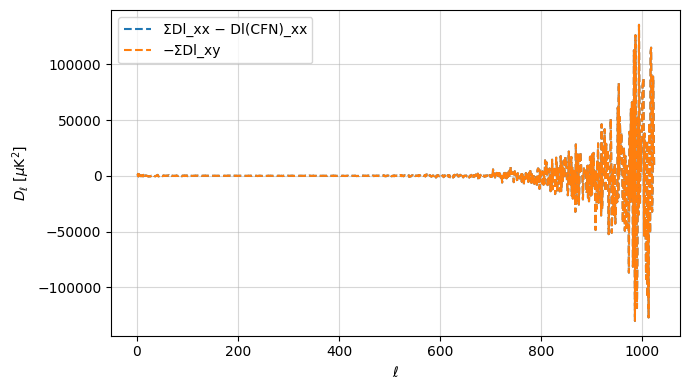

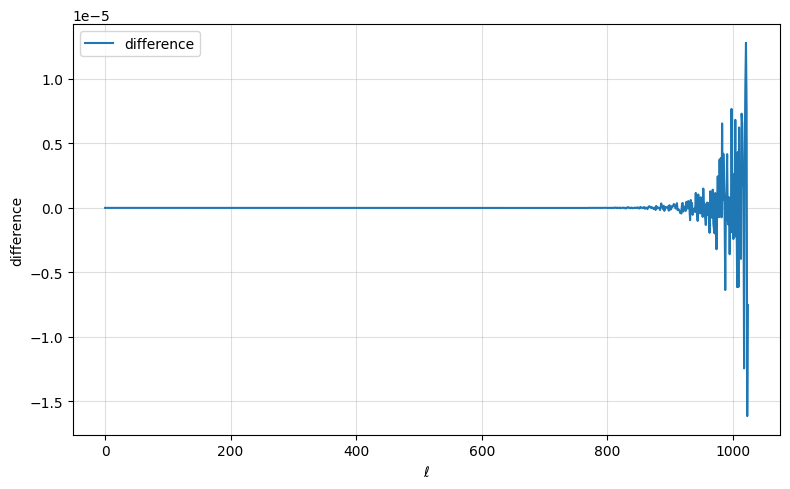

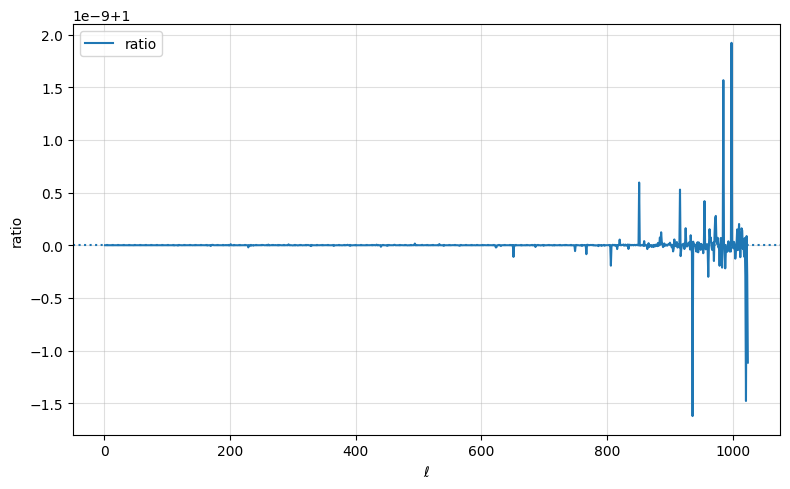

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure ℓ match
if not np.array_equal(ell_ref, ell_cfn):
    raise ValueError("ell_ref and ell_cfn differ; align ℓ before comparing.")

# Negative of the whole sum
Dl_neg_whole = -Dl_sum

# Plot residual vs negative whole
PowerSpectrumTT.plot_Dl_series([
    {"ell": ell_ref, "Dl": Dl_res,       "label": "ΣDl_xx − Dl(CFN)_xx", "source": "processed"},
    {"ell": ell_ref, "Dl": Dl_neg_whole, "label": "−ΣDl_xy",          "source": "processed"},
], save_path=None, show=True)

# given: ell_ref, Dl_sum, Dl_res
Dl_neg = -Dl_sum

# difference and ratio (no epsilon; set ratio to NaN where denominator is zero)
diff  = Dl_res - Dl_neg
ratio = np.where(Dl_neg != 0, Dl_res / Dl_neg, np.nan)

# plots
plt.figure(figsize=(8,5))
plt.plot(ell_ref, diff, label="difference")
plt.xlabel(r"$\ell$"); plt.ylabel("difference"); plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(ell_ref, ratio, label="ratio")
plt.axhline(1.0, linestyle=":")
plt.xlabel(r"$\ell$"); plt.ylabel("ratio"); plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()


In [26]:
pipe.step_wavelets()

--- PRODUCING WAVELET TRANSFORMS ---
Device 0: bytes_in_use=0 peak_bytes_in_use=18366208 bytes_limit=19069206528 largest_free_chunk=n/a num_allocs=100840
Wavelet coefficients for cfn at 030 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 030 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 044 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 044 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 070 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 070 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 100 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 100 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 143 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 143 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 217 GHz for realisation 0 already 

In [27]:
import os

ft = FileTemplates(directory="/Scratch/agnes/data")

# Pick which to inspect ( can include both)
dirs = [
    ft.output_directories["wavelet_coeffs"],   # per-scale directional wavelet maps
    ft.output_directories["scaling_coeffs"],   # scaling (low-pass) maps
]

for d in dirs:
    print(f"\n{d}:")
    if not os.path.exists(d):
        print("  (does not exist)")
        continue
    try:
        entries = sorted(os.listdir(d))
    except PermissionError as e:
        print(f"  (permission error) {e}")
        continue

    if not entries:
        print("  (empty)")
    else:
        for name in entries:
            print("  ", name)


/Scratch/agnes/data/wavelet_transforms/wavelet_coeffs:
   cfn_recon_f030_lmax128_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax1024_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax1028_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax1089_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax124_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax128_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax128_lam2.5.npy
   cfn_wavelet_f030_s0_r00000_lmax128_lam3.0.npy
   cfn_wavelet_f030_s0_r00000_lmax131_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax134_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax135_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax137_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax142_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax171_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax256_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax264_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax265_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax512_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax64_lam2.0.npy
   cfn_wavelet_f030_s10

In [28]:
import numpy as np

freq        = "143"
scale       = 9        
realisation = 0
lmax        = 512
lam         = 2.0
root        = "/Scratch/agnes/data/wavelet_transforms/wavelet_coeffs"

path = f"{root}/cfn_wavelet_f{freq}_s{scale}_r{realisation:05d}_lmax{lmax}_lam{lam}.npy"
w_band = np.load(path)

L = w_band.shape[0] if w_band.ndim == 2 else w_band.shape[1]

mw_alm = MWTools.wavelet_to_mw_alm(
    w_band,
    L=L,
    N_directions=1,
    lam=lam,
    reality=False,
    band_index=scale-1,  
)

KeyboardInterrupt: 

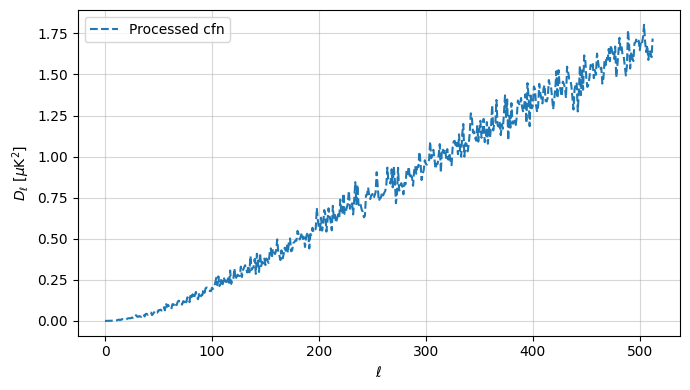

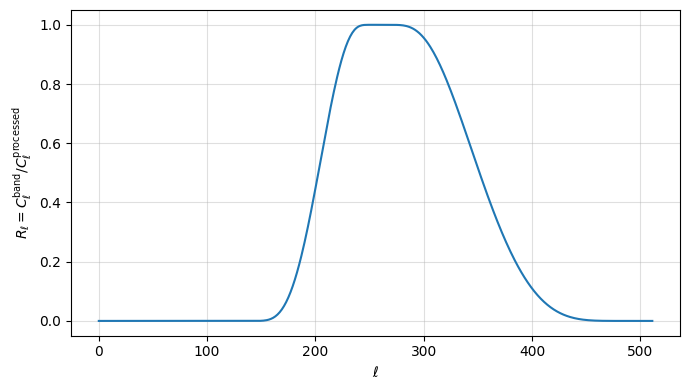

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- power from the wavelet band (MW alms) ---
def auto_cl_from_mw(a):
    L = a.shape[0]; m0 = L - 1
    Cl = np.empty(L)
    for l in range(L):
        sl = slice(m0 - l, m0 + l + 1)       # m = -l..+l
        Cl[l] = np.real(np.vdot(a[l, sl], a[l, sl])) / (2*l + 1)
    return np.arange(L), Cl

ell_band, Cl_band = auto_cl_from_mw(mw_alm)

# --- processed map power (same l-range) ---
component = "cfn"   # change to "tsz"/"cmb"/etc. to match what you want
ell_proc, Cl_proc = pipe.step_power_spec(
    unit="K",
    source="processed",
    component=component,
    frequency=freq,
    realisation=realisation,
    lmax=lmax,
)

# make lengths match: use first L multipoles of processed spectrum
L = Cl_band.size
Cl_proc = Cl_proc[:L]
ell_proc = ell_proc[:L]   # not strictly needed, but keeps ℓ aligned

# 2) restrict to where this band actually has power
band_pow_l = np.sum(np.abs(mw_alm)**2, axis=1)   # (L,)
mask = band_pow_l > 0

ell_use = ell_band[mask]
R       = Cl_band[mask] / (Cl_proc[mask] + 1e-30)

# 3) plot
plt.figure(figsize=(7,4))
plt.plot(ell_use, R)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$R_\ell = C_\ell^{\rm band} / C_\ell^{\rm processed}$')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


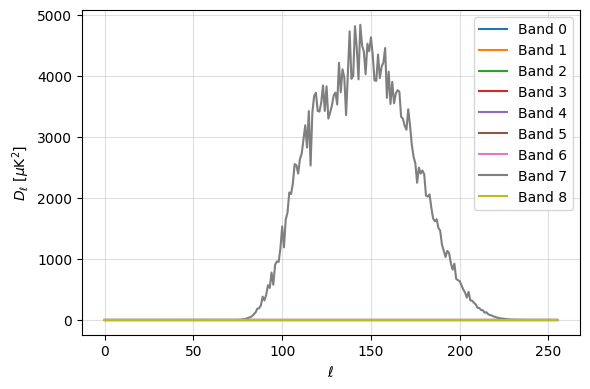

In [ ]:
import numpy as np
import jax.numpy as jnp
import s2fft
import s2wav
import s2wav.filters as filters

# --- inputs ---
freq        = "030"
scale       = 8                 # disk s{scale} -> band_index = scale-1
realisation = 0
lmax        = 1024
lam         = 2.0
root        = "/Scratch/agnes/data/wavelet_transforms/wavelet_coeffs"

# --- 1) per-band spectrum C_ell^{(j)} from single-band recon at its native L_band ---
path_band = f"{root}/cfn_wavelet_f{freq}_s{scale}_r{realisation:05d}_lmax{lmax}_lam{lam}.npy"
w_band = np.load(path_band)                                # e.g. (256, 511) for s8
L_band = w_band.shape[0] if w_band.ndim == 2 else w_band.shape[1]

mw_alm_band = MWTools.wavelet_to_mw_alm(                   # <-- use L_band here
    w_band,
    L=L_band,
    N_directions=1,
    lam=lam,
    reality=False,
    band_index=scale-1,  
)
ell, Cj = PowerSpectrumTT.from_mw_alm(mw_alm_band)         # C_ell^{(j)}

# --- 2) total spectrum C_ell^{tot} ---
# IMPORTANT: saved coeffs are multi-resolution, so don't try to synthesize all s1..sJ
# together at L_full in one call (they have different shapes). Instead, get C_tot from a full map
# already have, or from a previously computed full-resolution alm/map.

# If already have the full map or alm at lmax+1:
#   alm_full = ...  # (compute or load once at L_full = lmax+1)
#   ell_full, C_tot_full = PowerSpectrumTT.from_mw_alm(alm_full)
#   C_tot = C_tot_full[:L_band]  # truncate to match Cj's band-limit

# If DON'T have it handy, compare to theory |kappa|^2 directly:

# --- 3) theory |kappa|^2 from the SAME filters used in visualiser (at L_band) ---
wav_filters_band, scal_filter_band = filters.filters_directional_vectorised(L=L_band, N=1, lam=lam)
m0 = L_band - 1
psi_l0 = np.array(wav_filters_band[scale-1, :, m0])
kappa2 = (4.0*np.pi / (2.0*ell + 1.0)) * np.abs(psi_l0)**2


In [ ]:
# 1) Band-only spectrum from reconstructed mw_alm
ell_band, cl_band = PowerSpectrumTT.from_mw_alm(mw_alm)   # C_ell^{(j)}
# (Optional, identical ratio if use Dl instead of Cl)
Dl_band = PowerSpectrumTT.cl_to_Dl(ell_band, cl_band, input_unit="K")

# 2) Align totals to the band's ell-range (multi-resolution!)
L_band = len(ell_band)           
Cl_tot_use = cl_cfn[:L_band]
Dl_tot_use = Dl_cfn[:L_band]

# 3) Per-ℓ ratio (this is the per-band ratio)
Cl_ratio = cl_band / (Cl_tot_use)
Dl_ratio = Dl_band / (Dl_tot_use)   # numerically the same as Cl_ratio

# (Optional) quick sanity
# assert np.array_equal(ell_band, ell_cfn[:L_band])
print("mean ratio:", Cl_ratio.mean())


mean ratio: 0.29708602943712525


alpha ≈ 0.174321


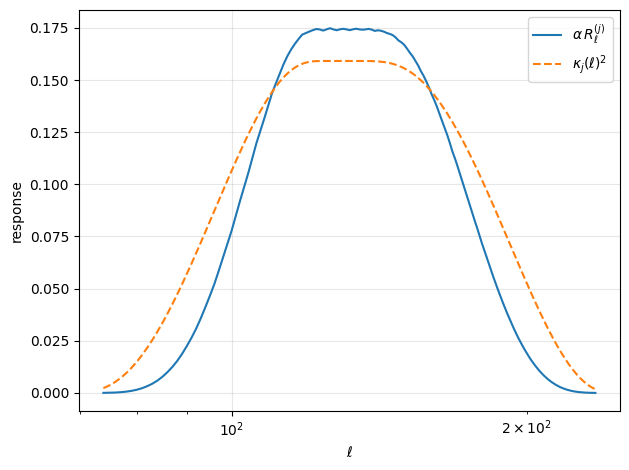

In [ ]:
# --- Direct, fixed comparison: should give alpha ≈ 1 when assumptions hold ---

# Per-ℓ ratio from spectra
ell_band, cl_band = PowerSpectrumTT.from_mw_alm(mw_alm_band)  # C_ell^(j)
L_band = len(ell_band)
R = cl_band / cl_cfn[:L_band]

# Axisymmetric filter (N=1) from the same L, scale
wav_filters, scal_filter = filters.filters_directional_vectorised(L=L_band, N=1, lam=lam)
j  = scale - 1                      # ensure this matches how mw_alm_band was produced
m0 = L_band - 1                     # m=0 column

# Convert harmonic response |Ψ_{ℓ0}|^2 to generating function κ_j(ℓ)^2
psi_harm_sq = np.abs(wav_filters[j, :, m0])**2
psi_gen_sq  = (4.0*np.pi)/(2.0*ell_band + 1.0) * psi_harm_sq   # κ_j(ℓ)^2

# Restrict to the passband & valid R
mask = (psi_gen_sq > 0.01 * psi_gen_sq.max()) & np.isfinite(R) & (R != 0)

R_in = R[mask]
P_in = psi_gen_sq[mask]

# Least-squares scale (should be ~1 if conventions match)
alpha = (R_in @ P_in) / (R_in @ R_in)

# Plot
plt.figure()
plt.semilogx(ell_band[mask], alpha * R_in, label=r"$\alpha\,R_\ell^{(j)}$")
plt.semilogx(ell_band[mask], P_in, "--", label=r"$\kappa_j(\ell)^2$")
plt.xlabel(r"$\ell$")
plt.ylabel("response")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Optional residual
# plt.figure()
# plt.semilogx(ell_band[mask], alpha * R_in - P_in)
# plt.xlabel(r"$\ell$")
# plt.ylabel(r"residual: $\alpha R_\ell^{(j)} - \kappa_j(\ell)^2$")
# plt.grid(alpha=0.3)
# plt.tight_layout()

print(f"alpha ≈ {alpha:.6g}")


# Cross spectrum of 'download' and 'processed'

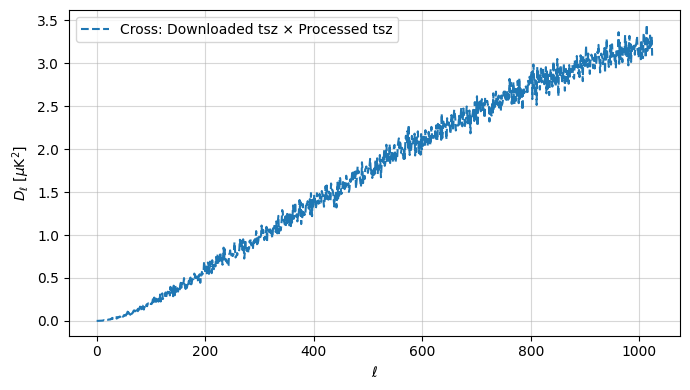

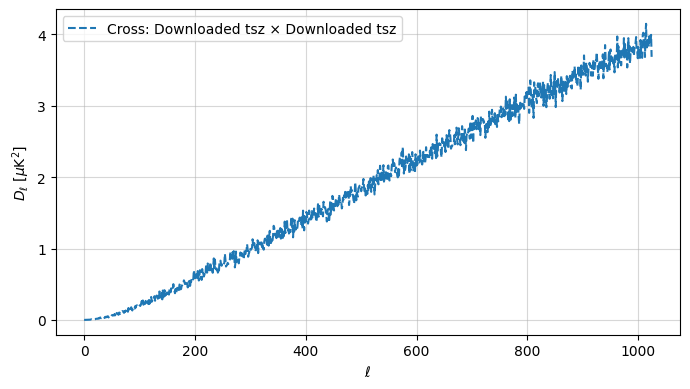

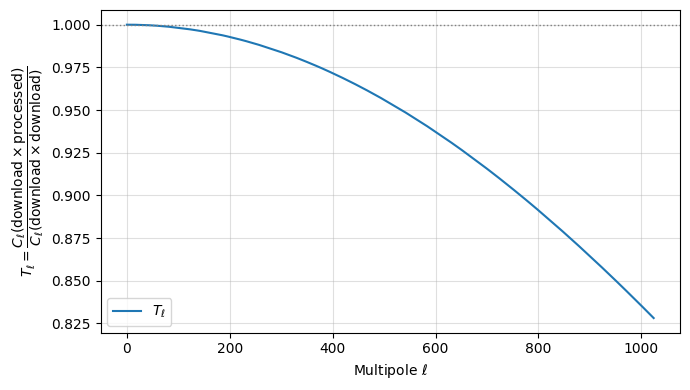

In [ ]:
frequency = '143'

# ---- 1) AFTER × BEFORE (download × processed) ----
ell_ab, Cl_ab = pipe.step_cross_power_spec(
    source_X="download",  component_X="tsz", frequency_X=frequency,   # BEFORE side
    source_Y="processed", component_Y="tsz", frequency_Y=frequency,   # AFTER side
    lmax=1024,
    unit="K",
    save_path=None
)

# ---- 2) BEFORE × BEFORE (download × download) ----
ell_bb, Cl_bb = pipe.step_cross_power_spec(
    source_X="download",  component_X="tsz", frequency_X=frequency,
    source_Y="download",  component_Y="tsz", frequency_Y=frequency,
    lmax=1024,
    unit="K",
    save_path=None
)

# ---- 3) Compute transfer ratio ----
import numpy as np
T_ell = Cl_ab / (Cl_bb)  # prevent division by zero

# ---- 4) Plot transfer ----
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(ell_ab, T_ell, label=r'$T_\ell$')

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$T_\ell = \dfrac{C_\ell(\text{download}\times\text{processed})}{C_\ell(\text{download}\times\text{download})}$')

plt.axhline(1.0, ls=':', color='gray', lw=1)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


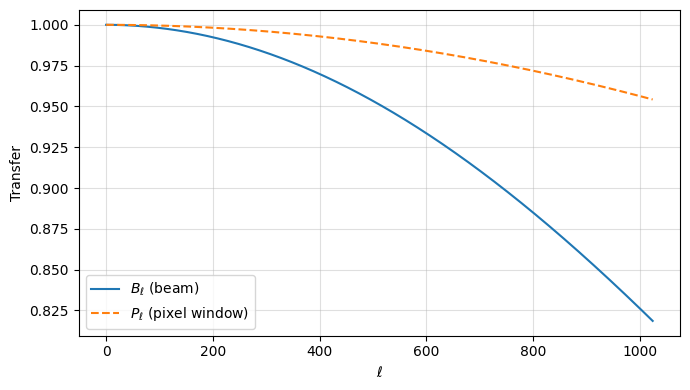

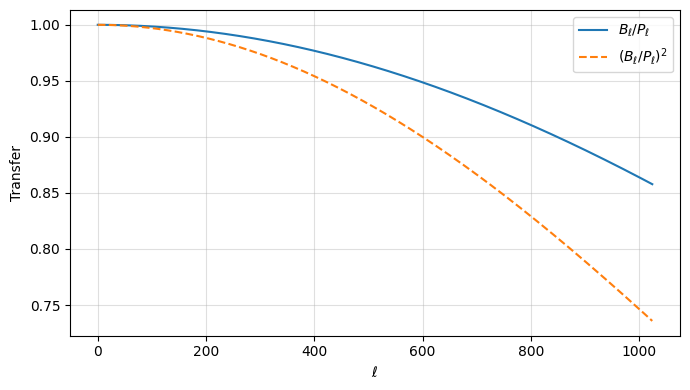

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# --- set params ---
nside = 1024
lmax  = 1024                  # will be capped to 3*nside-1 if larger
fwhm_arcmin = 5.0             # Gaussian beam FWHM (arcmin)
standard_fwhm_rad = np.radians(5/60)

# --- build ℓ grid and cap lmax to Nyquist ---
lmax = min(lmax, 3*nside - 1)
ell = np.arange(lmax + 1)

# --- B_ell (Gaussian beam) ---
fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)
B_l = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax, pol=False)  # shape (lmax+1,)

# --- P_ell (HEALPix pixel window for this nside) ---
P_full = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)                     # length ≈ 3*nside
P_l = P_full[:lmax + 1]

# --- plot ---
plt.figure(figsize=(7,4))
plt.plot(ell, B_l, label=r'$B_\ell$ (beam)')
plt.plot(ell, P_l, label=r'$P_\ell$ (pixel window)', linestyle='--')
plt.xlabel(r'$\ell$')
plt.ylabel('Transfer')
#plt.yscale('log')          
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- (B_l / P_l) and (B_l / P_l)^2 ---
H  = B_l / np.maximum(P_l, 1e-30)
H2 = H**2

plt.figure(figsize=(7,4))
plt.plot(ell, H,  label=r'$B_\ell/P_\ell$')
plt.plot(ell, H2, label=r'$(B_\ell/P_\ell)^2$', linestyle='--')
plt.xlabel(r'$\ell$')
plt.ylabel('Transfer')
#plt.yscale('log')          # optional
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

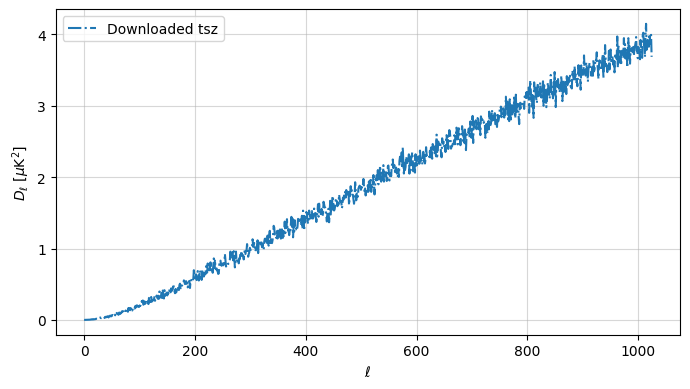

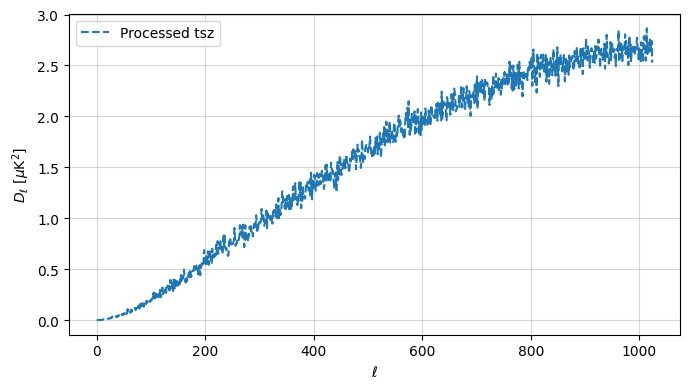

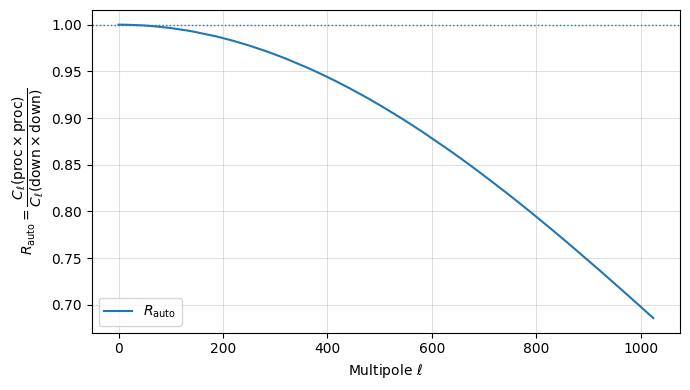

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lmax = 1024
frequency = "143"
realisation = 0  # set this if processed maps are split by realisation

# --- BEFORE: download × download (auto) ---
ell_down, Cl_down = pipe.step_power_spec(
    unit="K",
    source="downloaded",    
    component="tsz",
    frequency=frequency,
    lmax=lmax
)

# --- AFTER: processed × processed (auto) ---
ell_proc, Cl_proc = pipe.step_power_spec(
    unit="K",
    source="processed",
    component="tsz",
    frequency=frequency,
    realisation=realisation,
    lmax=lmax
)

# --- ratio (processed / download) ---
assert np.array_equal(ell_proc, ell_down), "ℓ grids differ; check lmax/masks"
R_auto = Cl_proc / (Cl_down)  # tiny epsilon for safety

# --- plot ---
plt.figure(figsize=(7,4))
plt.plot(ell_proc, R_auto, label=r'$R_{\rm auto}$')
plt.axhline(1.0, ls=':', lw=1)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$R_{\rm auto}=\dfrac{C_\ell(\mathrm{proc}\times\mathrm{proc})}{C_\ell(\mathrm{down}\times\mathrm{down})}$')
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


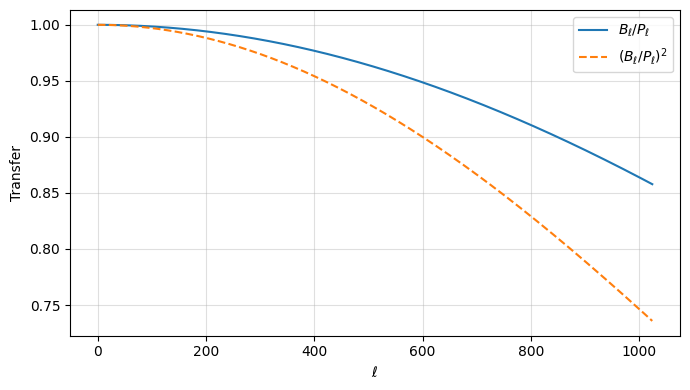

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# --- params (edit as needed) ---
nside = 1024
lmax  = 1024
standard_fwhm_rad = np.radians(5/60)

# --- setup ---
lmax = min(lmax, 3*nside - 1)
ell = np.arange(lmax + 1)

# --- B_ell (Gaussian beam) ---
fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)
B_l = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax, pol=False)  # (lmax+1,)

# --- P_ell (HEALPix pixel window) ---
P_l = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)[:lmax + 1]              # (lmax+1,)

# --- transfers ---
H = B_l / np.maximum(P_l, 1e-30)   # amplitude transfer B_l / P_l
H2 = H**2                          # power transfer (B_l / P_l)^2

# --- plot ---
plt.figure(figsize=(7,4))
plt.plot(ell, H,  label=r'$B_\ell/P_\ell$')
plt.plot(ell, H2, label=r'$(B_\ell/P_\ell)^2$', linestyle='--')
plt.xlabel(r'$\ell$')
plt.ylabel('Transfer')
# plt.yscale('log')  # uncomment for log-y if helpful
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

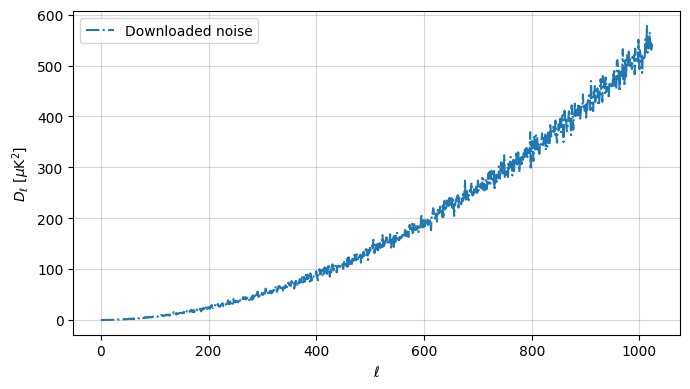

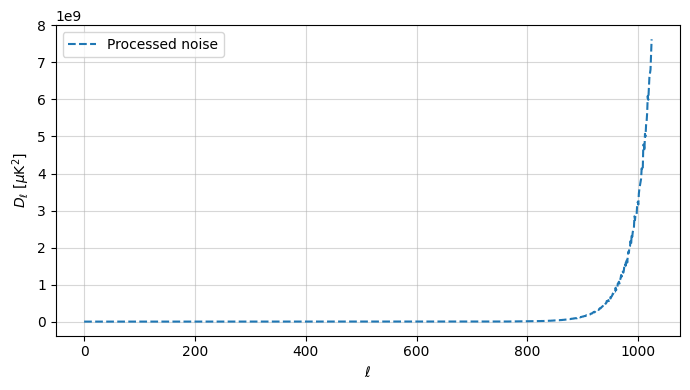

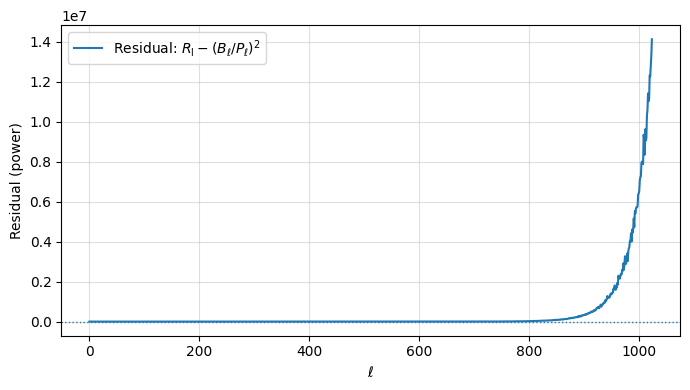

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

frequency = "143"
lmax = 1024
nside = 1024            
fwhm_arcmin = 5.0       
realisation = 0
standard_fwhm_rad = np.radians(5/60)

# ----- measured power ratio (auto/auto) -----
ell_down, Cl_down = pipe.step_power_spec(
    unit="K",
    source="downloaded",     
    component="tsz",           
    frequency=frequency,
    lmax=lmax
)
ell_proc, Cl_proc = pipe.step_power_spec(
    unit="K",
    source="processed",
    component="tsz",        
    frequency=frequency,
    realisation=realisation,
    lmax=lmax
)
assert np.array_equal(ell_proc, ell_down)
ell = ell_proc
R_auto = Cl_proc / (Cl_down)  # measured power transfer

# ----- theoretical (B_l/P_l)^2 on same ell grid -----
lmax_eff = min(lmax, 3*nside - 1)
ell = ell[:lmax_eff+1]
R_auto = R_auto[:lmax_eff+1]

fwhm_rad = np.deg2rad(fwhm_arcmin/60.0)
B_l = hp.gauss_beam(fwhm=fwhm_rad, lmax=lmax_eff, pol=False)
P_l = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)[:lmax_eff+1]
H2_th = (B_l / np.maximum(P_l, 1e-30))**2

# ----- residual and plot -----
res_power = R_auto - H2_th

plt.figure(figsize=(7,4))
plt.plot(ell, res_power, label=r'Residual: $R_{\rm l} - (B_\ell/P_\ell)^2$')
#plt.xlim(2, lmax_eff)
#plt.ylim(-1,2)
plt.axhline(0, ls=':', lw=1)
plt.xlabel(r'$\ell$'); plt.ylabel('Residual (power)')
plt.grid(alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()


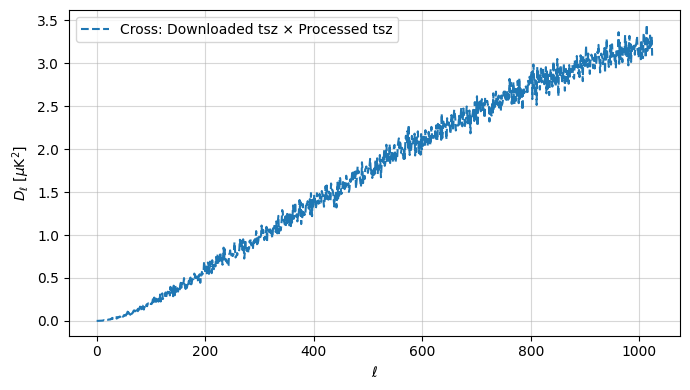

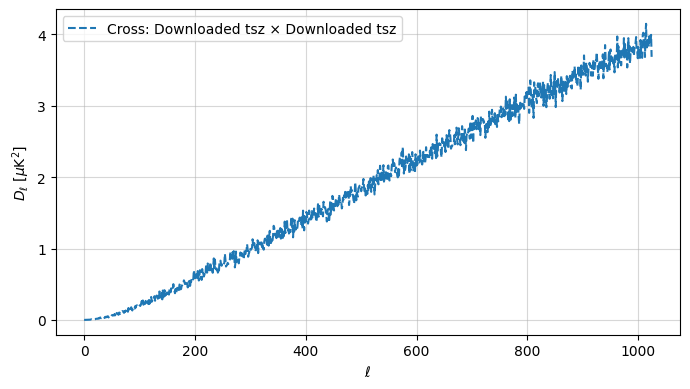

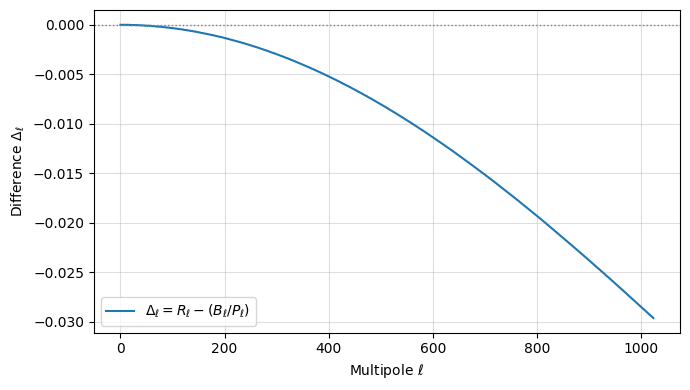

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# --- parameters ---
nside = 1024
lmax  = 1024
fwhm_arcmin = 5.0
frequency = "143"
standard_fwhm_rad = np.radians(5/60)

# ---- 1) AFTER × BEFORE (download × processed) ----
ell_ab, Cl_ab = pipe.step_cross_power_spec(
    source_X="download",  component_X="tsz", frequency_X=frequency,
    source_Y="processed", component_Y="tsz", frequency_Y=frequency,
    lmax=lmax, unit="K"
)

# ---- 2) BEFORE × BEFORE (download × download) ----
ell_bb, Cl_bb = pipe.step_cross_power_spec(
    source_X="download",  component_X="tsz", frequency_X=frequency,
    source_Y="download",  component_Y="tsz", frequency_Y=frequency,
    lmax=lmax, unit="K"
)

# ---- 3) Compute transfer ratio (measured) ----
T_ell = Cl_ab / (Cl_bb + 1e-30)

# ---- 4) Compute theoretical B_l / P_l ----
lmax = min(lmax, 3*nside - 1)
ell = np.arange(lmax + 1)

fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)
B_l = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax, pol=False)
P_l = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)[:lmax + 1]
H = B_l / np.maximum(P_l, 1e-30)

# ---- 5) Compute and plot residual ----
L = min(len(T_ell), len(H))
ell = ell[:L]
diff = T_ell[:L] - H[:L]

plt.figure(figsize=(7,4))
plt.plot(ell, diff, label=r'$\Delta_\ell = R_\ell - (B_\ell/P_\ell)$')
plt.axhline(0, ls=':', color='gray', lw=1)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'Difference $\Delta_\ell$')
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Debugging Aliasing